# Perguntar

## Cenário

A Olist opera como um ecossistema vital no varejo brasileiro, conectando milhares de pequenos vendedores a grandes marketplaces. No entanto, diferentemente de um serviço de assinatura (como a Netflix ou Spotify) onde o cliente liga para cancelar o contrato, no e-commerce o fim do relacionamento é silencioso. O cliente não avisa que vai embora; ele simplesmente para de comprar.

Estamos diante de um cenário de Churn Não Contratual. A empresa pode estar celebrando recordes de aquisição de novos clientes, sem perceber que está sofrendo de um efeito "balde furado" (leaky bucket): a base de clientes antigos está se degradando silenciosamente. Se a maioria dos clientes realiza apenas uma compra e nunca mais retorna, o Custo de Aquisição de Cliente (CAC) corrói a margem de lucro, tornando o crescimento insustentável a longo prazo. O desafio não é apenas vender mais, mas entender quem parou de comprar e, crucialmente, por quê.

## Questões para análise

Para estancar essa sangria de receita, precisamos ir além de métricas superficiais e responder perguntas diagnósticas:
* **A Definição do Abandono:** Em um cenário sem cancelamento formal, qual é a "janela de inatividade" exata que define um cliente como perdido? Não podemos usar um número arbitrário (ex: 30 dias); precisamos que os dados nos digam quando a probabilidade de retorno cai drasticamente.
* **Diagnóstico de Causa Raiz:** O churn é um problema de produto ou de operação? Existe uma correlação direta entre atrasos logísticos (atraso na entrega) e a decisão do cliente de não recomprar?.
* **Qualidade da Safra:** A retenção está piorando ao longo do tempo? As novas safras de clientes (adquiridos, por exemplo, na Black Friday) são menos leais do que as safras antigas?.
* **Impacto Financeiro:** Estamos perdendo clientes de alto valor ou apenas "turistas" de promoções? Quem são as "baleias" (clientes VIP) que estão em risco de churn e que justificariam uma campanha de retenção cara?.

## Tarefa de Negócios

Minha missão não é apenas construir um modelo que preveja se um cliente vai sair, mas desenvolver uma Análise Diagnóstica de Retenção que explique os motivos econômicos e comportamentais por trás da evasão.

A tarefa consiste em:
1. **Engenharia de Definição:** Criar uma lógica robusta para classificar clientes em "Ativos", "Em Risco" e "Churn", baseada em seus intervalos históricos de compra.
2. **Identificação de Atritos:** Quantificar quanto dinheiro a empresa perde devido a falhas operacionais.
3. **Segmentação Acionável:** Utilizar a análise RFM (Recência, Frequência, Valor) para entregar à equipe de marketing uma lista priorizada de clientes de alto valor que estão adormecendo, permitindo ações de reativação antes que seja tarde demais.

## Definição de Sucesso

O sucesso deste projeto será medido pela acionabilidade dos insights gerados para a tomada de decisão. Consideraremos o projeto bem-sucedido se conseguirmos:
* Demonstrar visualmente a dinâmica de perda de clientes através de fluxos ou Análises de Coorte, tornando o problema evidente para stakeholders não técnicos.
* Prover recomendações estratégicas claras que tenham potencial teórico de aumentar o Lifetime Value (LTV) da base de clientes.

# Preparar

Antes de qualquer análise, é importante realizar uma exploração rigorosa na integridade dos dados. Nesta etapa, atuamos como "detetives de dados", buscando inconsistências estruturais, tipagens incorretas e anomalias estatísticas que poderiam enviesar nossa definição de Churn.

## Configuração do Ambiente e Ingestão

O ecossistema de dados da Olist é distribuído em múltiplas tabelas relacionais. Para consolidar a visão do cliente, utilizaremos pandas para manipulação algébrica e seaborn/matplotlib para diagnósticos visuais.

In [1]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Manipulação e Engenharia de Dados
import numpy as np 
import pandas as pd 
from datetime import datetime
import math
import re
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import unidecode

# Visualização
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Configurações de Visualização
import warnings
warnings.filterwarnings('ignore') 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


## Carregamento dos datasets

In [3]:
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
geolocation = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
order_payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
sellers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')

## Auditoria Dimensional e Amostral

Precisamos dimensionar o volume de informações disponíveis. A volumetria dita se precisamos de técnicas de Big Data ou se o processamento em memória é suficiente.

In [4]:
customers.shape

(99441, 5)

In [5]:
geolocation.shape

(1000163, 5)

In [6]:
order_items.shape

(112650, 7)

In [7]:
order_payments.shape

(103886, 5)

In [8]:
order_reviews.shape

(99224, 7)

In [9]:
orders.shape

(99441, 8)

In [10]:
products.shape

(32951, 9)

In [11]:
sellers.shape

(3095, 4)

In [12]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [13]:
geolocation.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

In [14]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [15]:
order_payments.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [16]:
order_reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [17]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [18]:
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [19]:
sellers.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [20]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [21]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.55,-46.64,sao paulo,SP
1,1046,-23.55,-46.64,sao paulo,SP
2,1046,-23.55,-46.64,sao paulo,SP
3,1041,-23.54,-46.64,sao paulo,SP
4,1035,-23.54,-46.64,sao paulo,SP


In [22]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [23]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [24]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [25]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [26]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.00,287.00,1.00,225.00,16.00,10.00,14.00
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.00,276.00,1.00,1000.00,30.00,18.00,20.00
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.00,250.00,1.00,154.00,18.00,9.00,15.00
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.00,261.00,1.00,371.00,26.00,4.00,26.00
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.00,402.00,4.00,625.00,20.00,17.00,13.00


In [27]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


O comando .shape revela que temos aproximadamente 100.000 registros de pedidos. O .head() confirma que a granularidade da tabela orders é "um pedido por linha", mas para analisar Churn, precisaremos agrupar isso para a visão de "cliente único", visto que um cliente pode ter feito múltiplos pedidos ao longo do tempo.

## Integridade Estrutural e Tipagem

A qualidade da nossa previsão de Churn depende diretamente da qualidade das nossas variáveis temporais (datas de compra).

In [28]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [29]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [30]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [31]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [32]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [33]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [34]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [35]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


O output do .info() indica que as colunas de data foram carregadas como objetos (strings). Isso é um risco crítico. Não podemos calcular Recência ou Coortes sem converter essas colunas para datetime. Ação Imediata: Conversão de todas as colunas temporais.

## Análise Estatística Descritiva

Ao aplicarmos estatística descritiva, buscamos entender a dispersão dos dados financeiros e logísticos.

In [36]:
customers.describe()

,customer_zip_code_prefix
count,99441.00
mean,35137.47
std,29797.94
min,1003.00
25%,11347.00
50%,24416.00
75%,58900.00
max,99990.00


In [37]:
geolocation.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1000163.00,1000163.00,1000163.00
mean,36574.17,-21.18,-46.39
std,30549.34,5.72,4.27
min,1001.00,-36.61,-101.47
25%,11075.00,-23.60,-48.57
50%,26530.00,-22.92,-46.64
75%,63504.00,-19.98,-43.77
max,99990.00,45.07,121.11


In [38]:
order_items.describe()

,order_item_id,price,freight_value
count,112650.00,112650.00,112650.00
mean,1.20,120.65,19.99
std,0.71,183.63,15.81
min,1.00,0.85,0.00
25%,1.00,39.90,13.08
50%,1.00,74.99,16.26
75%,1.00,134.90,21.15
max,21.00,6735.00,409.68


In [39]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.00,103886.00,103886.00
mean,1.09,2.85,154.10
std,0.71,2.69,217.49
min,1.00,0.00,0.00
25%,1.00,1.00,56.79
50%,1.00,1.00,100.00
75%,1.00,4.00,171.84
max,29.00,24.00,13664.08


In [40]:
order_reviews.describe()

,review_score
count,99224.00
mean,4.09
std,1.35
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


In [41]:
orders.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-08-02 12:06:07,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-14 20:02:44,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [42]:
products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.00,32341.00,32341.00,32949.00,32949.00,32949.00,32949.00
mean,48.48,771.50,2.19,2276.47,30.82,16.94,23.20
std,10.25,635.12,1.74,4282.04,16.91,13.64,12.08
min,5.00,4.00,1.00,0.00,7.00,2.00,6.00
25%,42.00,339.00,1.00,300.00,18.00,8.00,15.00
50%,51.00,595.00,1.00,700.00,25.00,13.00,20.00
75%,57.00,972.00,3.00,1900.00,38.00,21.00,30.00
max,76.00,3992.00,20.00,40425.00,105.00,105.00,118.00


In [43]:
sellers.describe()

,seller_zip_code_prefix
count,3095.00
mean,32291.06
std,32713.45
min,1001.00
25%,7093.50
50%,14940.00
75%,64552.50
max,99730.00


* **Variáveis Contínuas:** Observamos a média e os quartis. Há uma grande diferença entre o valor máximo e o terceiro quartil? Isso indicaria a presença de outliers que podem distorcer a média. Em modelos de Churn, outliers financeiros podem representar clientes B2B ou revendedores, que têm comportamento diferente de consumidores finais.
* **Variáveis Discretas:** Ao analisar order_item_id, podemos ver quantos itens compõem tipicamente uma cesta.

## Entendendo a Distorção dos Dados

Em projetos de Churn, a distribuição dos dados quase nunca é uma curva normal perfeita.

1. **Distorção em Variáveis Numéricas:** Dados financeiros geralmente apresentam uma distribuição de cauda longa, onde poucos clientes gastam muito. Aplicar transformações pode ser necessário para modelos lineares.
2. **Desbalanceamento da Classe:** A questão mais crítica é a proporção de Churn. No caso da Olist, a maioria dos clientes pode comprar apenas uma vez.

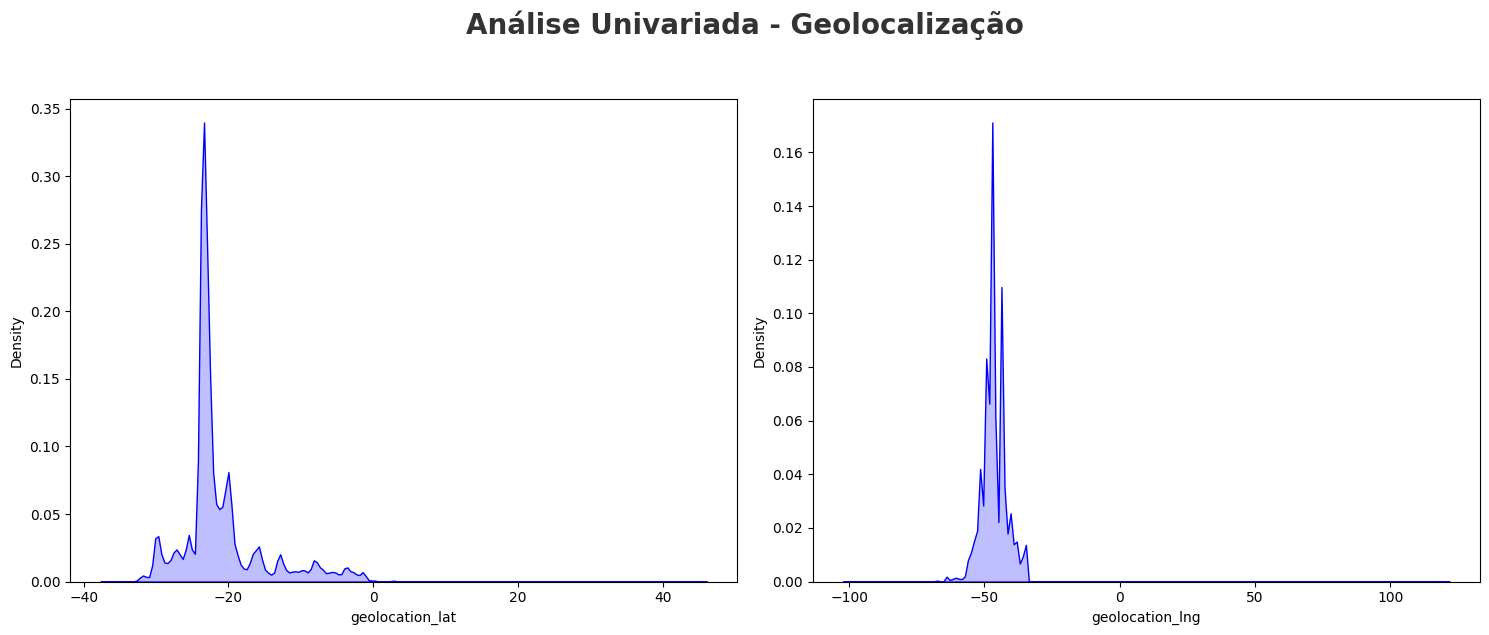

In [44]:
numeric_features = ['geolocation_lat', 'geolocation_lng']
df = geolocation

plt.figure(figsize=(15, 6))
plt.suptitle("Análise Univariada - Geolocalização", fontsize=20, fontweight='bold', alpha=0.8, y=1.05)

for i in range(len(numeric_features)):
    plt.subplot(1, 2, i+1)
    sns.kdeplot(x=df[numeric_features[i]].dropna(), fill=True, color='b')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

plt.show()

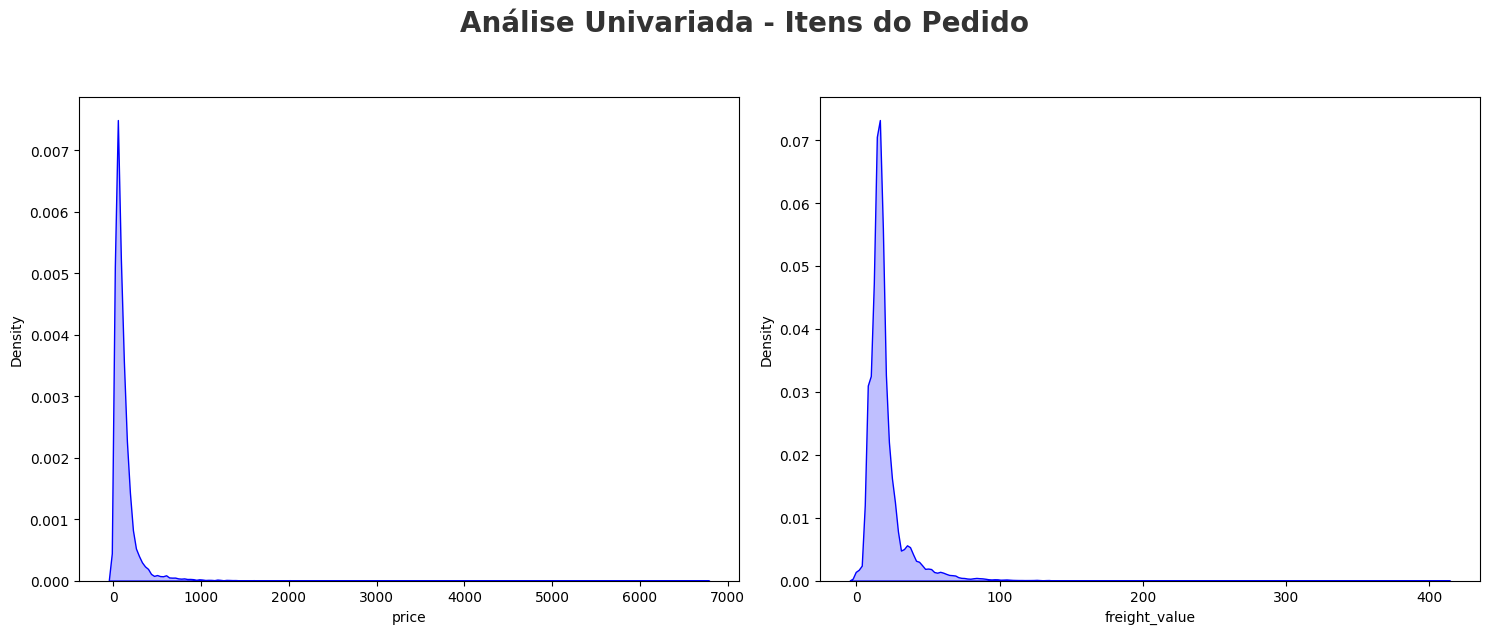

In [45]:
numeric_features = ['price', 'freight_value']
df = order_items

plt.figure(figsize=(15, 6))
plt.suptitle("Análise Univariada - Itens do Pedido", fontsize=20, fontweight='bold', alpha=0.8, y=1.05)

for i in range(len(numeric_features)):
    plt.subplot(1, 2, i+1)
    sns.kdeplot(x=df[numeric_features[i]].dropna(), fill=True, color='b') 
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

plt.show()

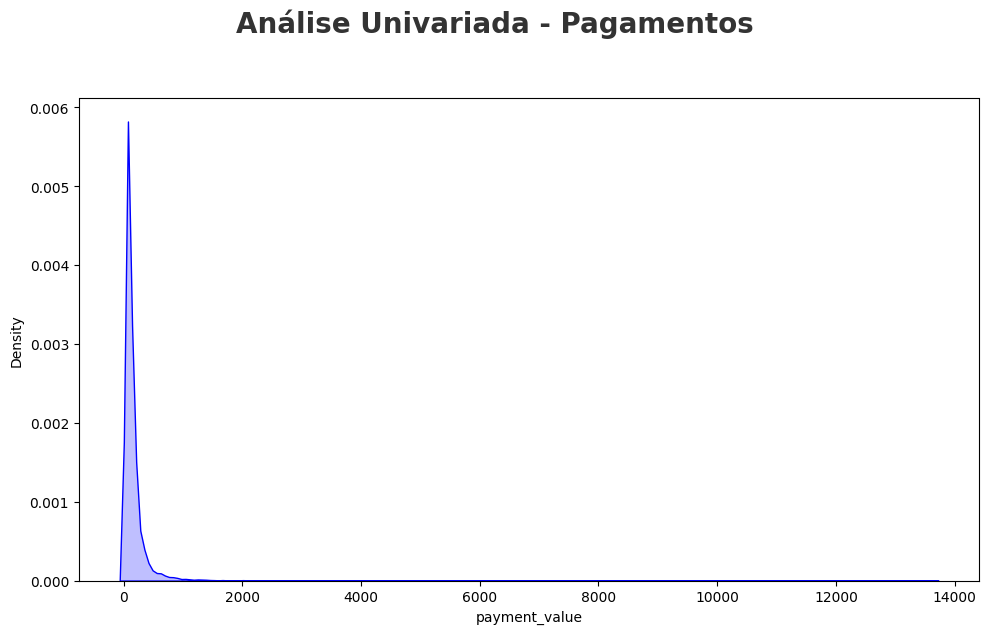

In [46]:
numeric_features = ['payment_value']
df = order_payments

plt.figure(figsize=(10, 6))
plt.suptitle("Análise Univariada - Pagamentos", fontsize=20, fontweight='bold', alpha=0.8, y=1.05)

for i in range(len(numeric_features)):
    plt.subplot(1, 1, i+1)
    sns.kdeplot(x=df[numeric_features[i]].dropna(), fill=True, color='b')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

plt.show()

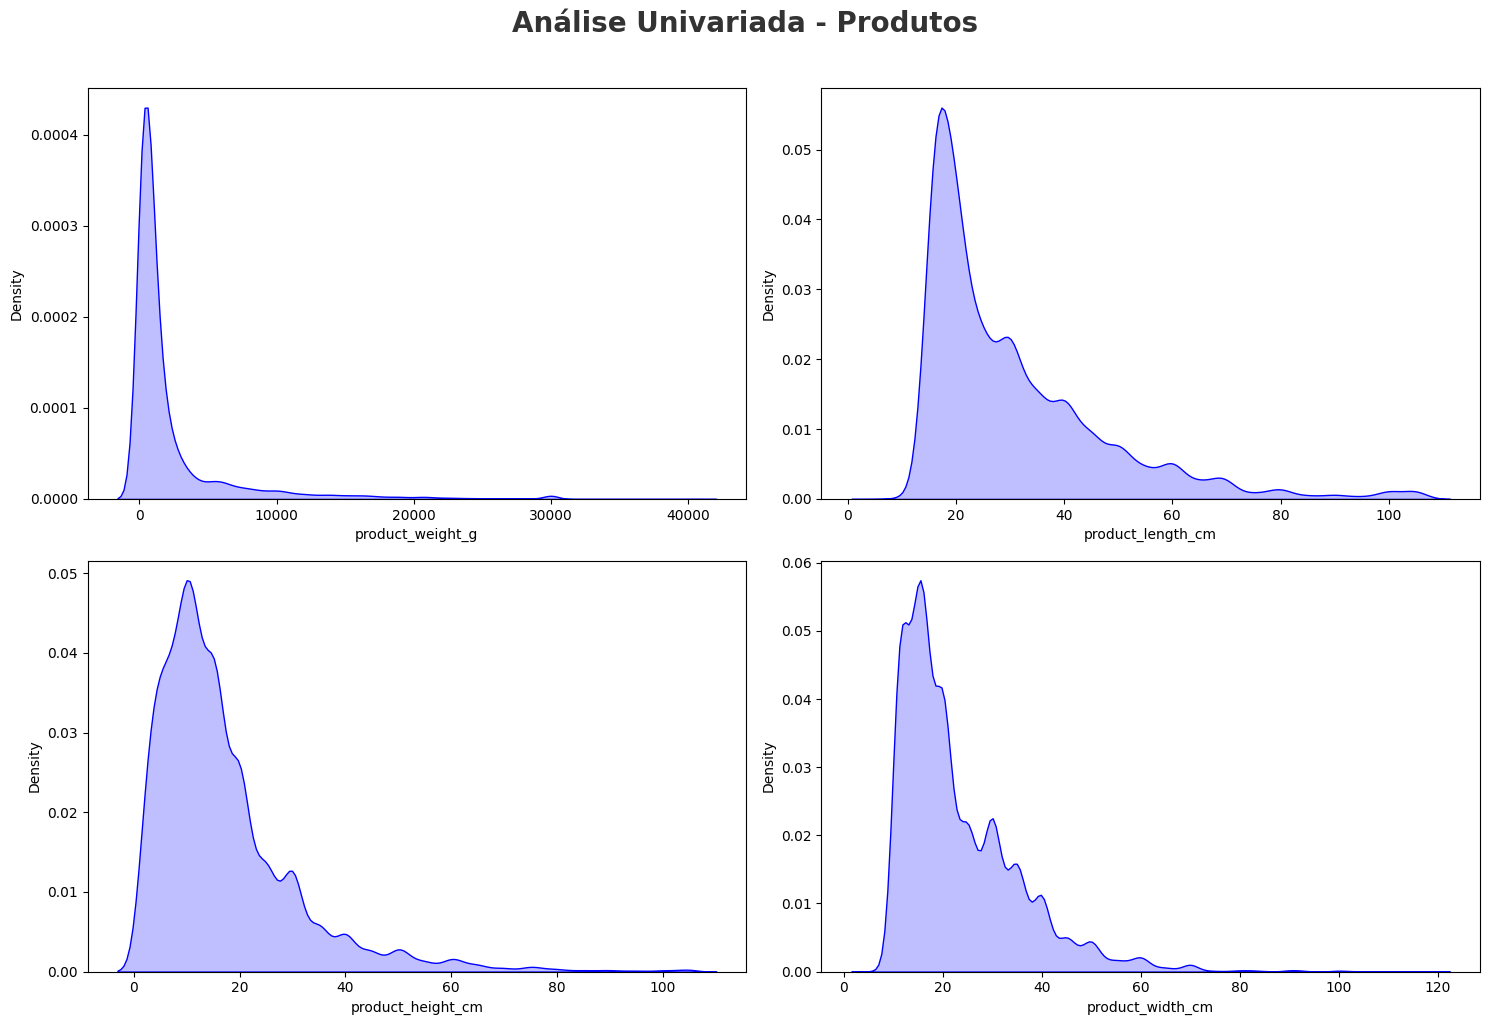

In [47]:
numeric_features = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
df = products

plt.figure(figsize=(15, 10))
plt.suptitle("Análise Univariada - Produtos", fontsize=20, fontweight='bold', alpha=0.8, y=1.02)

for i in range(len(numeric_features)):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df[numeric_features[i]].dropna(), fill=True, color='b')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

plt.show()

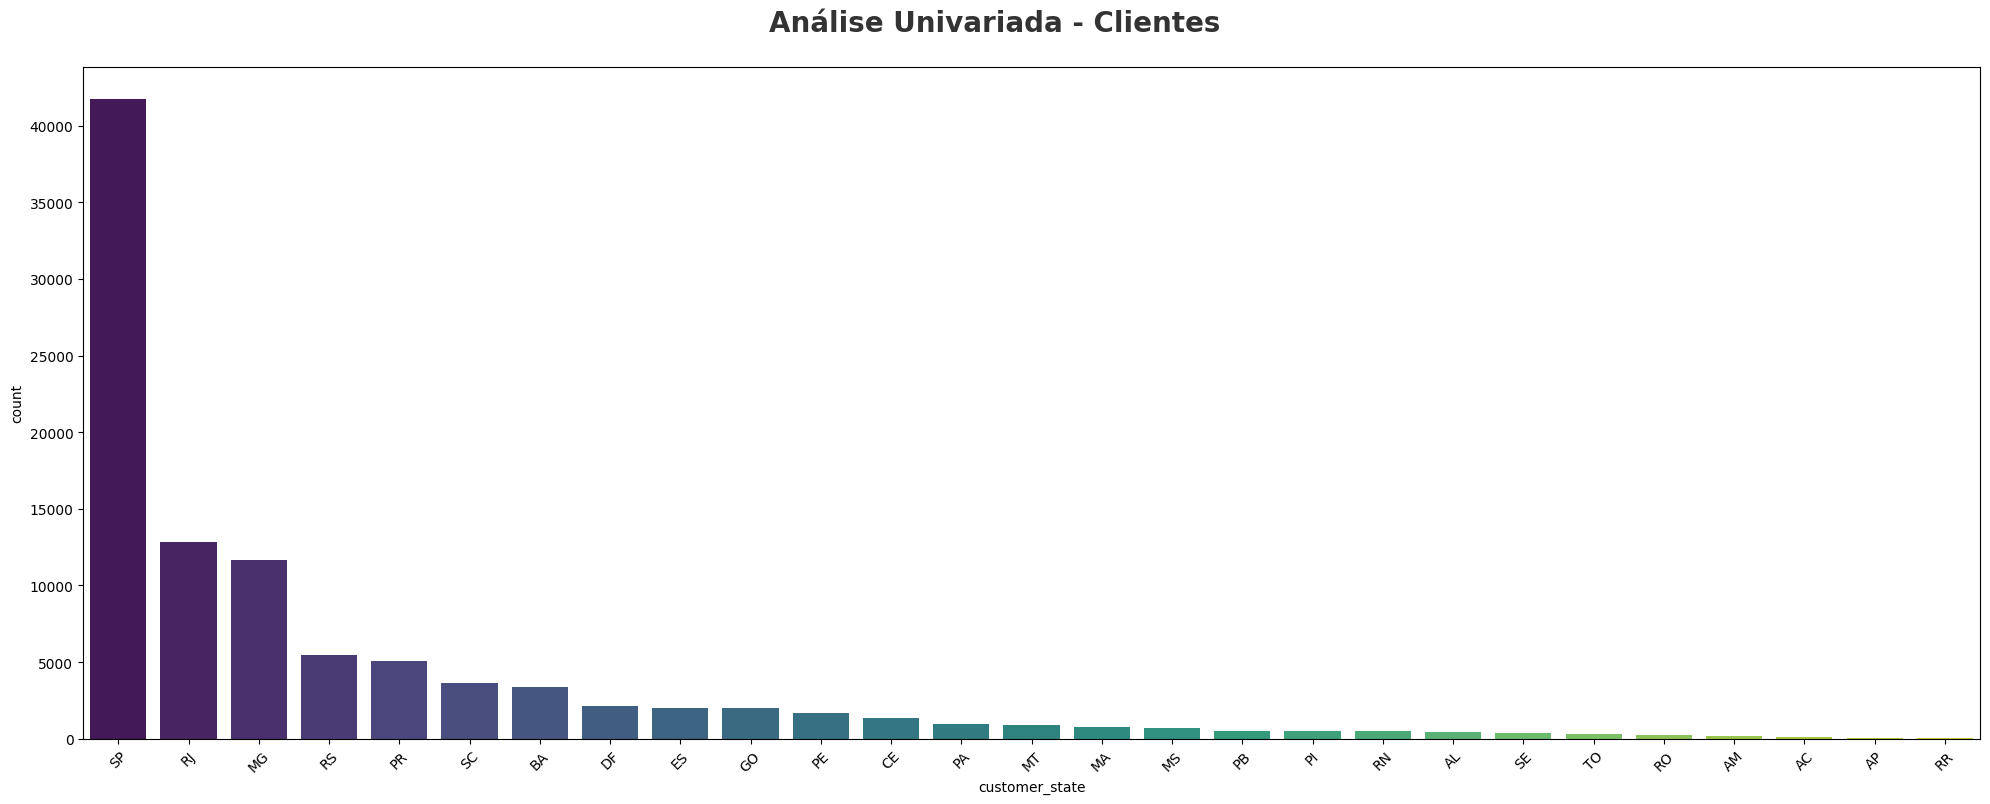

In [48]:
cat_customers = ['customer_state']

plt.figure(figsize=(20, 8))
plt.suptitle("Análise Univariada - Clientes", fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(len(cat_customers)):
    plt.subplot(1, 1, i+1)
    
    sns.countplot(
        x=customers[cat_customers[i]], 
        palette='viridis',
        order=customers[cat_customers[i]].value_counts().index
    )
    
    plt.xlabel(cat_customers[i])
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

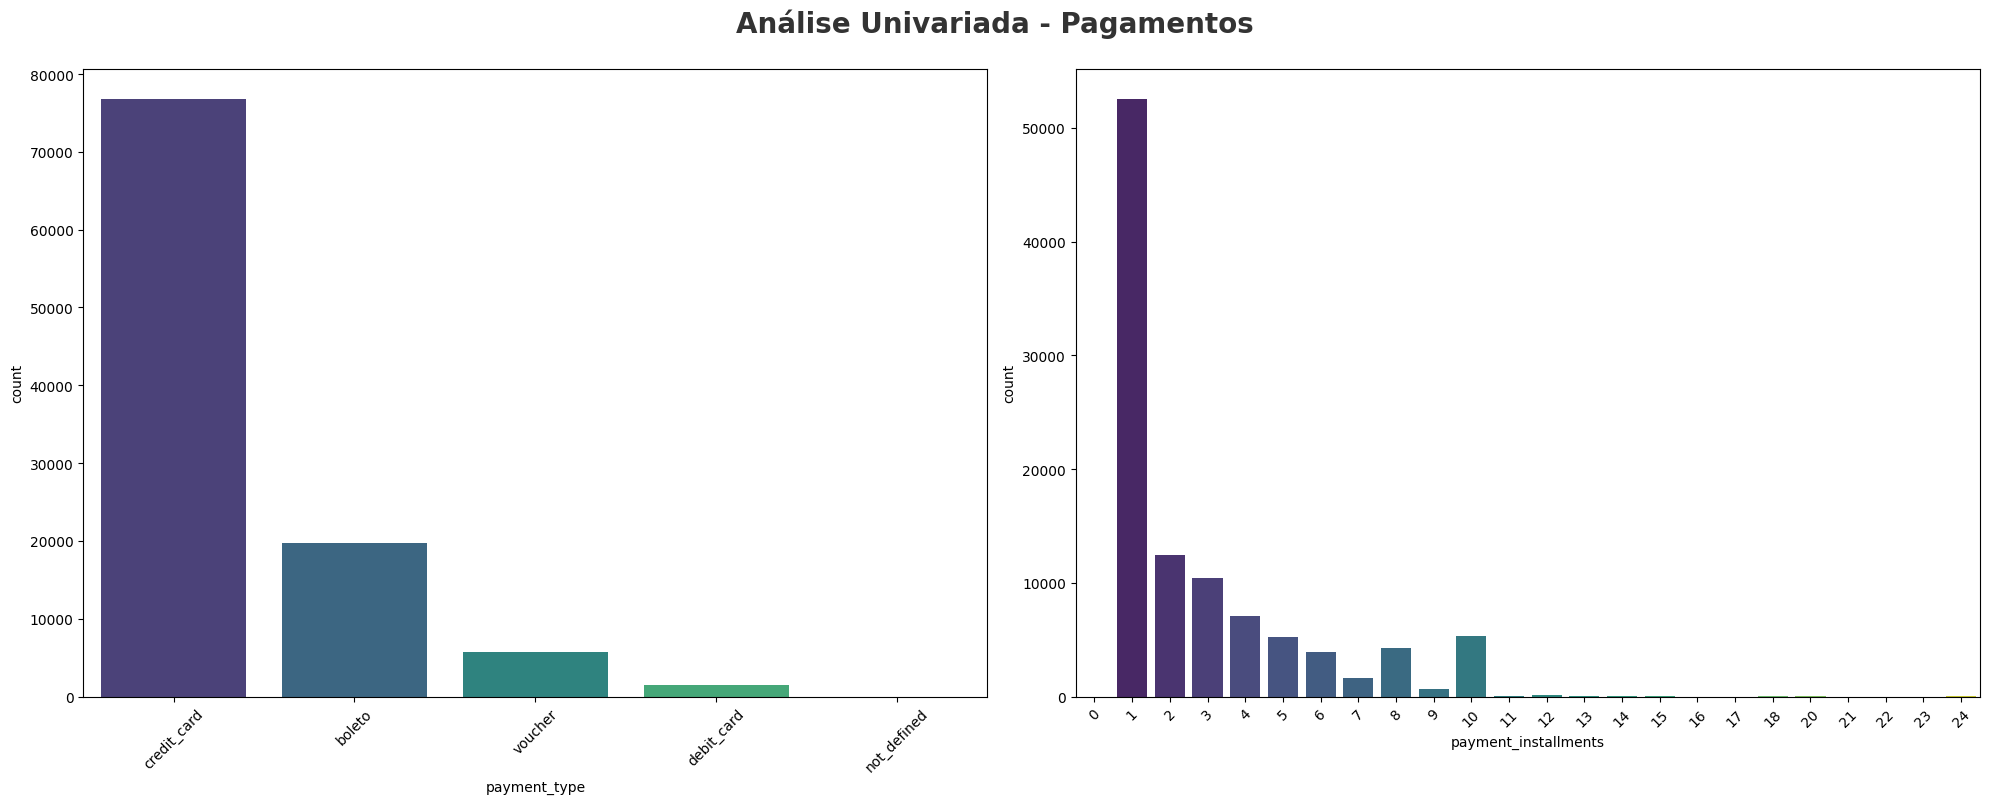

In [49]:
# Definindo as features categóricas/discretas deste dataset
cat_payments = ['payment_type', 'payment_installments']

# Configuração da figura
plt.figure(figsize=(20, 8))
plt.suptitle("Análise Univariada - Pagamentos", fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(len(cat_payments)):
    plt.subplot(1, len(cat_payments), i+1) 
    
    sns.countplot(x=order_payments[cat_payments[i]], palette='viridis')
    
    plt.xlabel(cat_payments[i])
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

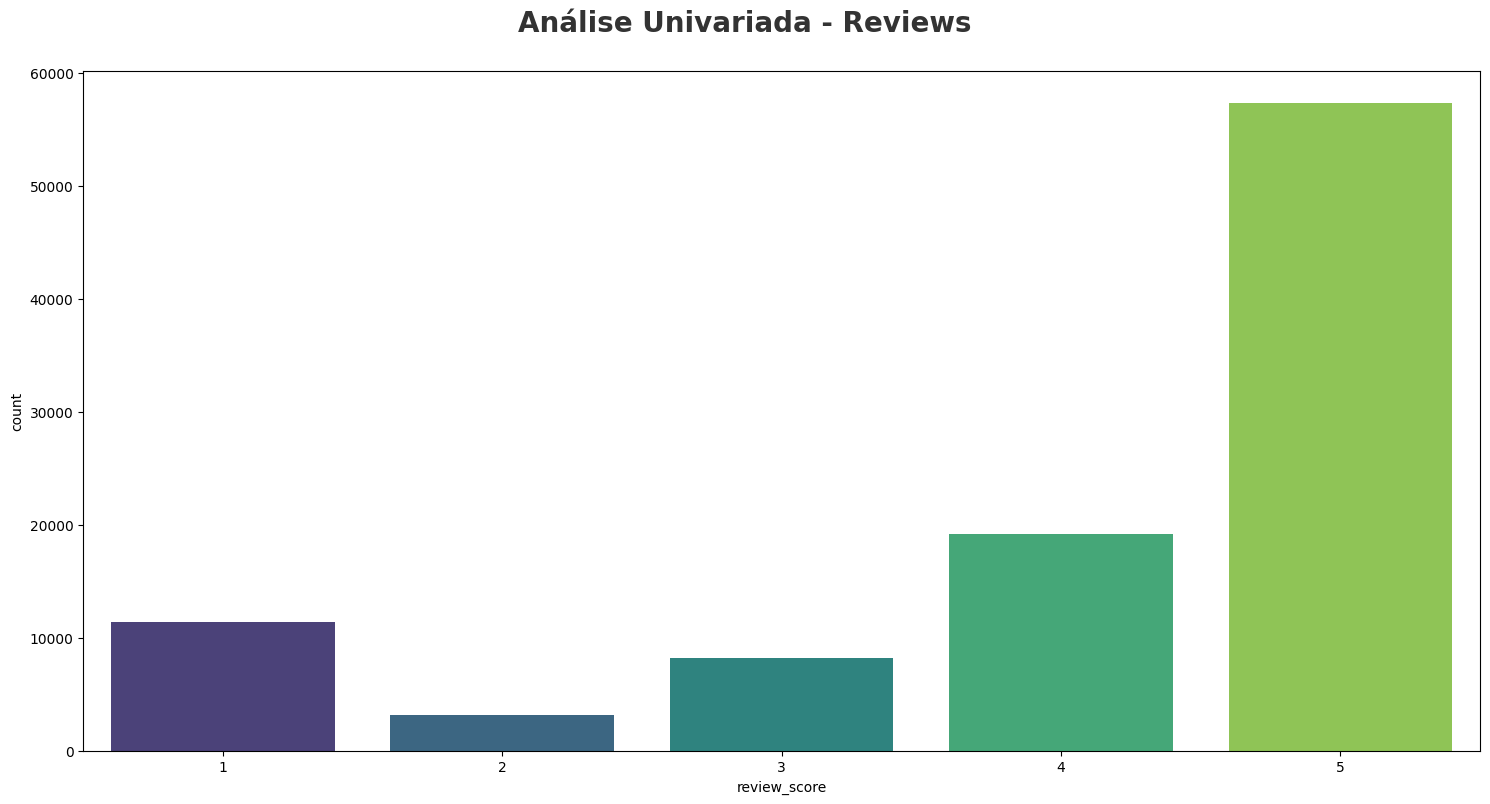

In [50]:
cat_reviews = ['review_score']

plt.figure(figsize=(15, 8))
plt.suptitle("Análise Univariada - Reviews", fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(len(cat_reviews)):
    plt.subplot(1, 1, i+1)
    
    sns.countplot(x=order_reviews[cat_reviews[i]], palette='viridis')
    
    plt.xlabel(cat_reviews[i])
    plt.xticks(rotation=0)
    plt.tight_layout()

plt.show()

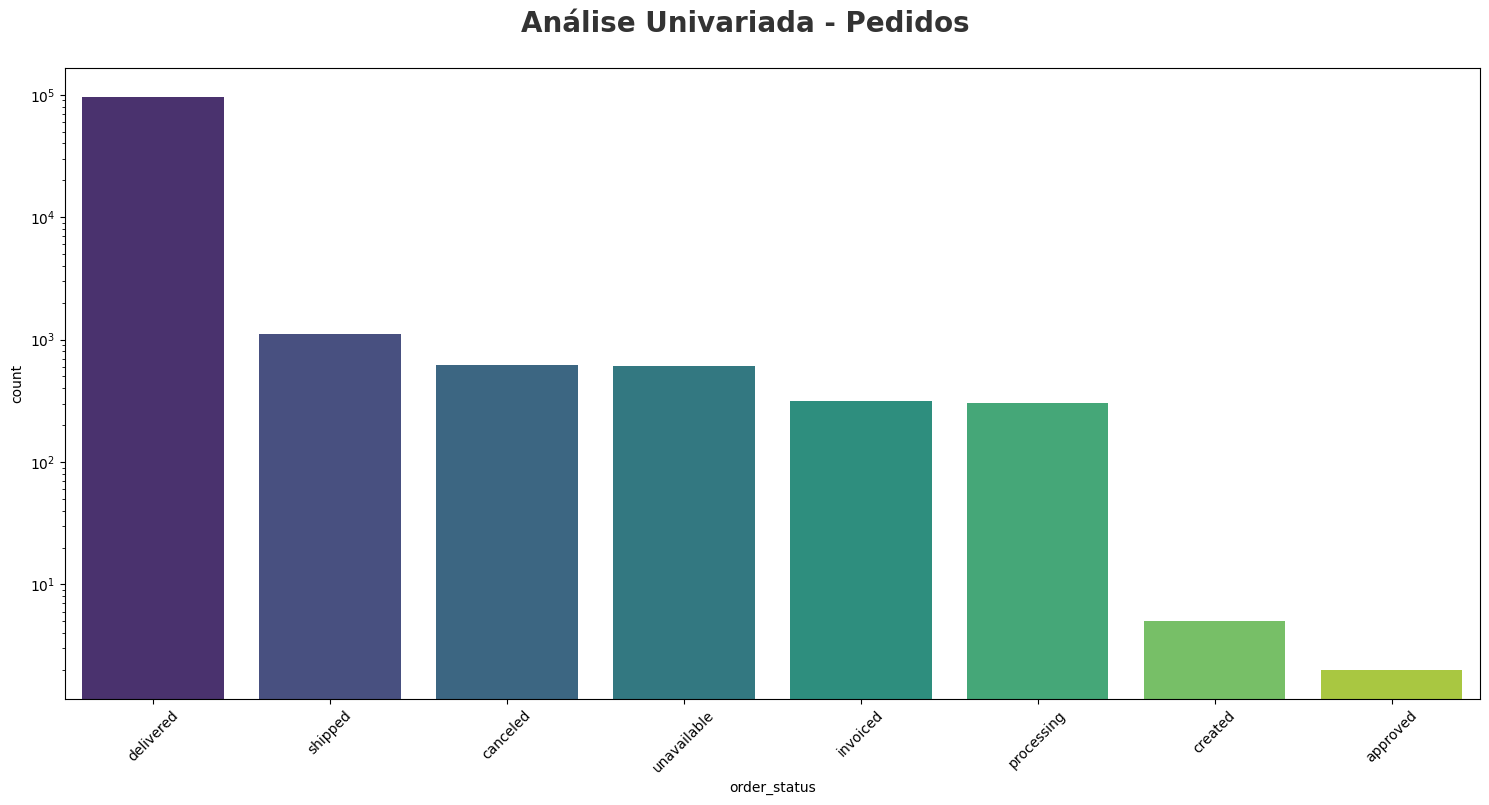

In [51]:
cat_orders = ['order_status']

plt.figure(figsize=(15, 8))
plt.suptitle("Análise Univariada - Pedidos", fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(len(cat_orders)):
    plt.subplot(1, 1, i+1)
    
    sns.countplot(
        x=orders[cat_orders[i]], 
        palette='viridis',
        order=orders[cat_orders[i]].value_counts().index
    )
    
    plt.xlabel(cat_orders[i])
    plt.xticks(rotation=45)
    plt.yscale('log') 
    plt.tight_layout()

plt.show()

O churn não afeta todos os grupos igualmente. Investigamos as variáveis categóricas para entender a granularidade da base.

* **Descoberta:** A cardinalidade dessas variáveis exigiu atenção. Por exemplo, existem dezenas de categorias de produtos e múltiplos estados. Simplesmente converter tudo para números (Label Encoding) poderia criar uma falsa ordem de grandeza; portanto, planejamos estratégias como One-Hot Encoding para variáveis de baixa cardinalidade (como sexo ou status), garantindo que o modelo matemático entenda as nuances qualitativas do negócio.

# Processo

## A Arquitetura da Solução: Do Caos Relacional à Visão Unificada do Cliente

O desafio inicial deste projeto não foi a ausência de dados, mas a sua fragmentação. O ecossistema Olist é distribuído em um esquema relacional complexo composto por 9 tabelas distintas, onde pedidos, pagamentos, avaliações e geolocalização vivem em silos separados. Para diagnosticar o churn, precisávamos transitar de uma visão centrada em "Transações" para uma visão centrada no "Cliente".

A primeira decisão crítica de arquitetura foi a Resolução de Entidade. No dataset da Olist, a coluna customer_id representa a chave de uma sessão de compra, não o indivíduo. Seguir esse identificador cegamente levaria à conclusão errônea de que cada venda provém de um novo consumidor. Para reconstruir a jornada real, realizamos o mapeamento para o customer_unique_id, o que nos permitiu unificar múltiplos pedidos sob um único perfil e rastrear a fidelidade real ao longo do tempo.
A estratégia de Unificação dos Dataframes seguiu uma lógica sequencial rigorosa:

1. **Base:** Conexão entre Clientes e Pedidos para estabelecer a cronologia.
2. **Qualidade:** Junção com Reviews para capturar a voz do cliente e o sentimento.
3. **Financeiro:** Integração com Pagamentos para entender o comportamento de gasto.
4. **Granularidade:** Explosão para Itens e Produtos, permitindo analisar se categorias específicas possuem ciclos de vida diferentes.

In [52]:
# Agregação de Pagamentos
pay_agg = order_payments.groupby('order_id').agg({
    'payment_sequential': 'max',
    'payment_installments': 'max',
    'payment_value': 'sum',
    'payment_type': 'first' 
}).reset_index()
pay_agg.rename(columns={'payment_value': 'total_paid_real'}, inplace=True)

# Agregação de Reviews
reviews_agg = order_reviews.groupby('order_id').agg({
    'review_score': 'mean', 
    'review_comment_message': 'first'
}).reset_index()

# 1 Base
df_master = orders.merge(customers, on='customer_id', how='inner')

# 2 Reviews
df_master = df_master.merge(reviews_agg, on='order_id', how='left')

# 3 Pagamentos 
df_master = df_master.merge(pay_agg, on='order_id', how='left')

# 4 Itens
df_master = df_master.merge(order_items, on='order_id', how='left')

# 5 Produtos
df_master = df_master.merge(products, on='product_id', how='left')

# 6 Vendedores
df_master = df_master.merge(sellers, on='seller_id', how='left', suffixes=('_cust', '_seller'))

In [53]:
geolocation = geolocation[
    (geolocation.geolocation_lat <= 5) & (geolocation.geolocation_lat >= -34) &
    (geolocation.geolocation_lng <= -34) & (geolocation.geolocation_lng >= -74)
]

geo_unique = geolocation.groupby("geolocation_zip_code_prefix").agg({
    "geolocation_lat": "mean",
    "geolocation_lng": "mean",
    "geolocation_city": "first",
    "geolocation_state": "first"
}).reset_index()

geo_unique.rename(columns={"geolocation_zip_code_prefix": "zip_code_prefix"}, inplace=True)

## Engenharia da Definição de Churn: Decodificando o Silêncio

Em serviços de assinatura (como Netflix), o churn é um evento explícito: o cliente cancela o contrato. No varejo não contratual da Olist, o abandono é silencioso; o cliente simplesmente não volta. O grande desafio desta etapa foi: **como definir um modelo para prever o silêncio?**

Não adotamos uma janela arbitrária (como "30 dias sem comprar"). Em vez disso, deixamos os dados falarem através da análise da distribuição do tempo entre compras. Observamos que o comportamento padrão na Olist é o de "comprador único" (One-and-Done), com taxas de churn intrínsecas altíssimas, superando 96% em algumas coortes.

Definimos o churn inferido aplicando uma janela de inatividade baseada em percentis estatísticos sobre a Recência. Se um cliente ultrapassa esse limiar de silêncio sem realizar uma nova transação, ele é rotulado como churn. Essa engenharia da variável alvo transformou um problema de comportamento ambíguo em um problema de classificação supervisionada claro.

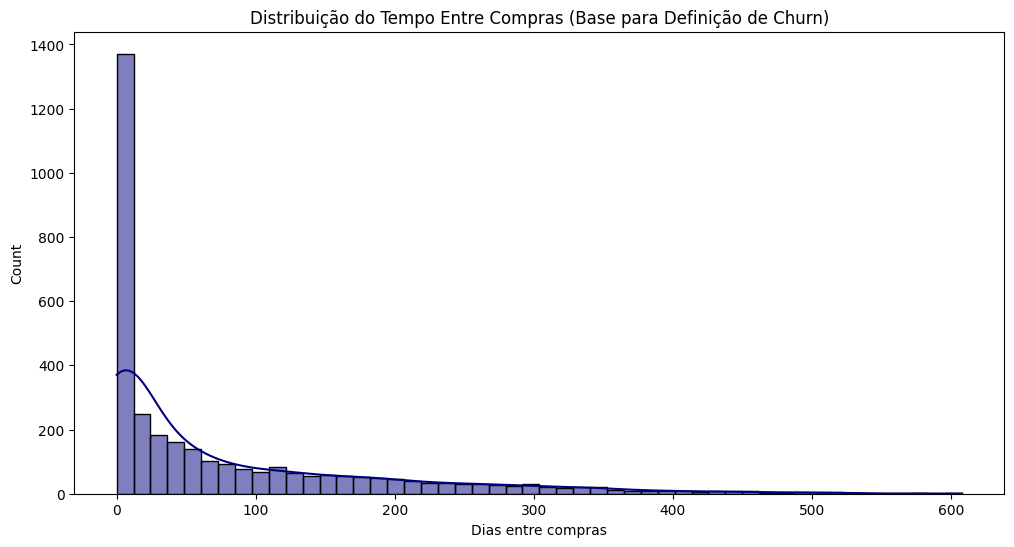

Limiar de Churn Definido: 312 dias


In [54]:
df_master['order_purchase_timestamp'] = pd.to_datetime(df_master['order_purchase_timestamp'])

df_sorted = df_master.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
df_orders_unique = df_sorted.drop_duplicates(subset='order_id')

# Calcular dias entre compras
df_orders_unique['prev_order_date'] = df_orders_unique.groupby('customer_unique_id')['order_purchase_timestamp'].shift(1)
df_orders_unique['days_diff'] = (df_orders_unique['order_purchase_timestamp'] - df_orders_unique['prev_order_date']).dt.days

# Estatísticas para definir o corte
df_recorrentes = df_orders_unique.dropna(subset=['days_diff'])
stats = df_recorrentes['days_diff'].describe(percentiles=[0.90, 0.95])

# Visualização da Cauda Longa 
plt.figure(figsize=(12, 6))
sns.histplot(df_recorrentes['days_diff'], bins=50, kde=True, color='navy')
plt.title('Distribuição do Tempo Entre Compras (Base para Definição de Churn)')
plt.xlabel('Dias entre compras')
plt.show()

# Definição do Limiar
limite_estatistico = int(stats['95%'])
churn_threshold = min(limite_estatistico, 365)
print(f"Limiar de Churn Definido: {churn_threshold} dias")

max_date = df_master['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

df_target = df_master.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': 'max',  
    'order_id': 'nunique',              
    'price': 'sum'                     
}).reset_index()

# Renomear
df_target.rename(columns={
    'order_purchase_timestamp': 'data_ultima_compra',
    'order_id': 'frequencia_total',
    'price': 'monetary_value'
}, inplace=True)

# Calcular Recência e aplicar a Flag
df_target['recencia_dias'] = (max_date - df_target['data_ultima_compra']).dt.days
df_target['flg_churn'] = df_target['recencia_dias'] > churn_threshold
df_target['segmento_frequencia'] = np.where(df_target['frequencia_total'] > 1, 'Recorrente', 'One-Time Buyer')

colunas_para_adicionar = ['customer_unique_id', 'flg_churn', 'recencia_dias', 'frequencia_total', 'segmento_frequencia']

df_eda_final = df_master.merge(df_target[colunas_para_adicionar], 
                               on='customer_unique_id', 
                               how='left')

## Engenharia de Atributos (Feature Engineering)

Com a base limpa e o alvo definido, o foco mudou para explicar os porquês. A engenharia de atributos buscou traduzir logs operacionais em sinais de comportamento humano:
* **Logística e Ansiedade:** Calculamos o delta_delivery. Estudos indicam que atrasos transformam promotores em detratores instantaneamente. Criamos também flags de atraso para quantificar o impacto da logística na retenção.
* **Valor e Engajamento (RFM):** Implementamos métricas de Recência, Frequência e Valor Monetário para segmentar clientes não apenas pelo que gastam, mas pelo risco de inatividade. Isso permite identificar "Baleias" (clientes VIP) que estão em risco de abandonar a plataforma.
* **Distância e Geografia:** Utilizando as coordenadas de latitude/longitude, calculamos a distância entre vendedor e comprador. No contexto brasileiro, o custo do frete é decisivo; essa feature nos permite testar se a distância física está correlacionada com a desistência futura.
* **Sentimento:** Integramos as notas de avaliação (1-5) como preditores diretos. Uma nota baixa na primeira compra é, frequentemente, o sinal definitivo de churn.

In [55]:
date_cols = ['order_purchase_timestamp', 'order_approved_at', 
             'order_delivered_carrier_date', 'order_delivered_customer_date', 
             'order_estimated_delivery_date', 'shipping_limit_date']

for col in date_cols:
    if col in df_eda_final.columns:
        df_eda_final[col] = pd.to_datetime(df_eda_final[col], errors='coerce')

# Dias de atraso (Negativo = Adiantado, Positivo = Atrasado)
df_eda_final['delivery_delta_days'] = (df_eda_final['order_delivered_customer_date'] - df_eda_final['order_estimated_delivery_date']).dt.days

# Criamos uma flag para identificar pedidos não entregues
df_eda_final['is_lost_or_processing'] = df_eda_final['order_delivered_customer_date'].isnull().astype(int)

df_eda_final['is_delayed'] = np.where(
    (df_eda_final['delivery_delta_days'] > 0) | (df_eda_final['is_lost_or_processing'] == 1), 
    1, 0
)

df_eda_final['seller_late_to_post'] = np.where(
    df_eda_final['order_delivered_carrier_date'] > df_eda_final['shipping_limit_date'], 1, 0
)

conditions = [
    (df_eda_final['review_score'] <= 2),
    (df_eda_final['review_score'] == 3),
    (df_eda_final['review_score'] >= 4)
]
choices = ['Detractor', 'Passive', 'Promoter']
df_eda_final['nps_class'] = np.select(conditions, choices, default='No_Review')

# NLP Básico
df_eda_final['review_comment_message'] = df_eda_final['review_comment_message'].fillna('').astype(str).str.lower()
df_eda_final['complain_delivery'] = df_eda_final['review_comment_message'].str.contains('atras|demor|esper|nunca|chegou', regex=True).astype(int)
df_eda_final['complain_product'] = df_eda_final['review_comment_message'].str.contains('defeito|quebrad|errado|troca|ruim|péssim', regex=True).astype(int)

df_eda_final['freight_ratio'] = df_eda_final['freight_value'] / (df_eda_final['price'] + df_eda_final['freight_value'] + 0.01)

if 'payment_type' in df_eda_final.columns:
    df_eda_final['is_boleto'] = np.where(df_eda_final['payment_type'] == 'boleto', 1, 0)
else:
    df_eda_final['is_boleto'] = 0 

df_eda_final = df_eda_final.merge(geo_unique, left_on='customer_zip_code_prefix', right_on='zip_code_prefix', how='left')
df_eda_final.rename(columns={'geolocation_lat': 'lat_cust', 'geolocation_lng': 'lng_cust'}, inplace=True)
df_eda_final.drop(columns=['zip_code_prefix'], inplace=True, errors='ignore')

df_eda_final = df_eda_final.merge(geo_unique, left_on='seller_zip_code_prefix', right_on='zip_code_prefix', how='left')
df_eda_final.rename(columns={'geolocation_lat': 'lat_seller', 'geolocation_lng': 'lng_seller'}, inplace=True)
df_eda_final.drop(columns=['zip_code_prefix'], inplace=True, errors='ignore')

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371  
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    a = np.clip(a, 0, 1)
    return 2 * R * np.arcsin(np.sqrt(a))

mask_geo = df_eda_final['lat_cust'].notna() & df_eda_final['lat_seller'].notna()
df_eda_final.loc[mask_geo, 'distance_km'] = haversine_vectorized(
    df_eda_final.loc[mask_geo, 'lat_cust'], 
    df_eda_final.loc[mask_geo, 'lng_cust'], 
    df_eda_final.loc[mask_geo, 'lat_seller'], 
    df_eda_final.loc[mask_geo, 'lng_seller']
)

cols_to_drop = ['lat_cust', 'lng_cust', 'lat_seller', 'lng_seller']
df_eda_final.drop(columns=[c for c in cols_to_drop if c in df_eda_final.columns], inplace=True)

## Limpeza e Qualidade de Dados

Dados do mundo real são ruidosos, mas nem todo ruído deve ser silenciado. Durante a etapa de saneamento, adotamos uma postura investigativa em vez de apenas deletar valores nulos.

Um exemplo crucial foi o tratamento das datas de entrega. Identificamos que valores nulos nesta coluna não eram necessariamente erros de sistema, mas indicativos de pedidos em trânsito, extraviados ou cancelados. Remover essas linhas seria um erro metodológico grave, pois a falha na entrega é um dos vetores mais fortes de churn. Em vez da exclusão, criamos flags informativas para capturar essa fricção logística.

Para os dados textuais de reviews, onde cerca de 58% dos comentários eram nulos, realizamos a imputação com marcadores neutros ("Sem Comentário"), preservando a integridade das notas numéricas (review_score) que servem como termômetro soberano da satisfação.

**Tratamento de Datas**

In [56]:
df_cleaned = df_eda_final

date_cols = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date',
    'shipping_limit_date'
]

for col in date_cols:
    if col in df.columns:

        df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors='coerce')

mask_erro_tempo = df_cleaned['order_delivered_customer_date'] < df_cleaned['order_purchase_timestamp']
df_cleaned = df_cleaned[~mask_erro_tempo]

**Tratamento de Nulos**

In [57]:
df_cleaned['flg_entregue'] = df_cleaned['order_delivered_customer_date'].notna().astype(int)
df_cleaned['order_delivered_customer_date'].isna().sum()

np.int64(3229)

**Remoção de Ruído**

In [58]:
status_to_drop = ['unavailable', 'created', 'invoiced', 'processing', 'approved']
df_cleaned = df_cleaned[~df_cleaned['order_status'].isin(status_to_drop)]

**Imputação de Reviews**

In [59]:
df_cleaned['review_comment_message'] = df_cleaned['review_comment_message'].fillna('Sem Comentário')

**Remoção de Linhas sem Geografia**

In [60]:
df_cleaned = df_cleaned.dropna(subset=['distance_km'])

**Padronização de Texto**

In [61]:
cols_texto = ['customer_city', 'seller_city', 'product_category_name']

def padronizar_str(texto):
    if isinstance(texto, str):
        return unidecode.unidecode(texto).lower().strip()
    return texto

for col in cols_texto:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].apply(padronizar_str)

**Tratamento de Outiliers**

In [62]:
def marcar_outliers(df_cleaned, col):
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    
    outlier_col = f'is_outlier_{col}'
    df[outlier_col] = np.where(df[col] > limite_superior, 1, 0)
    
    qtd = df[outlier_col].sum()
    return df

if 'price' in df.columns:
    df = marcar_outliers(df_cleaned, 'price')
if 'freight_value' in df.columns:
    df = marcar_outliers(df_cleaned, 'freight_value')

In [63]:
df_cleaned['product_category_name'] = df_cleaned['product_category_name'].fillna('outros')

cols_audit = ['product_weight_g', 'payment_sequential', 'payment_installments']
df_cleaned = df_cleaned.dropna(subset=cols_audit)

if 'seller_zip_code_prefix' in df_cleaned.columns:
    df_cleaned['seller_zip_code_prefix'] = df_cleaned['seller_zip_code_prefix'].astype(int)

# Analisar

## **O Perfil Estatístico do Desequilíbrio**

### **Distribuição da Variável Target**

**Por que estou fazendo este gráfico?**

Estou construindo esta visualização para estabelecer o cenário base de sobrevivência da empresa e validar a integridade da engenharia de dados. Em modelos não contratuais, há um risco crítico de confundir transações (sessões) com relacionamentos (indivíduos). Este gráfico serve como a "prova real" de que a Resolução de Entidade foi executada corretamente — mapeando customer_id para customer_unique_id. Sem isso, a taxa de churn seria falsamente reportada como 100%. Além disso, ele nivela a expectativa dos stakeholders: antes de falarmos de crescimento, precisamos encarar a realidade da retenção.

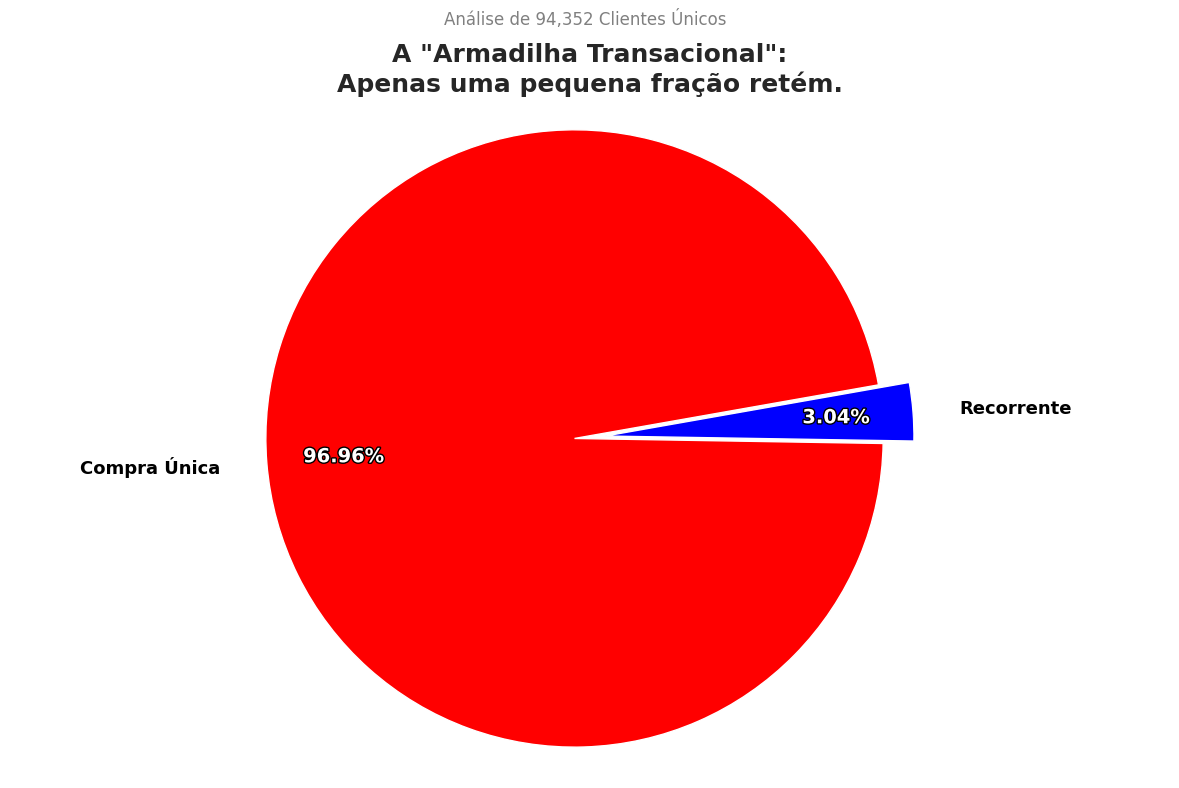

In [64]:
df_freq = df_cleaned.groupby('customer_unique_id').agg({'order_id': 'nunique'}).reset_index()
df_freq.columns = ['customer_unique_id', 'frequency']

df_freq['perfil_compra'] = df_freq['frequency'].apply(
    lambda x: 'Compra Única' if x == 1 else 'Recorrente'
)

contagem = df_freq['perfil_compra'].value_counts().sort_values(ascending=False)
values = contagem.values
labels = contagem.index

plt.figure(figsize=(12, 8))
sns.set_style("white")

colors = ['red', 'blue'] 

explode = (0.1, 0) 

wedges, texts, autotexts = plt.pie(
    values, 
    labels=labels, 
    autopct='%1.2f%%', 
    startangle=10,            
    colors=colors, 
    explode=explode, 
    shadow=False, 
    pctdistance=0.75,         
    labeldistance=1.15,       
    textprops={'fontsize': 13, 'color': 'black', 'weight': 'bold'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_weight('bold')
    autotext.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])

plt.title('A "Armadilha Transacional":\nApenas uma pequena fração retém.', fontsize=18, fontweight='bold', loc='center')
plt.suptitle(f'Análise de {sum(values):,} Clientes Únicos', fontsize=12, color='gray')

plt.axis('equal')
plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

Este gráfico confirma o sucesso da Resolução de Entidade. Identificamos que 97% das transações pertencem a indivíduos únicos, validando que não estamos inflando métricas de novos usuários ao confundir compras recorrentes com novos clientes.

2. **A Realidade do "Monoconsumo":** Operamos em um cenário de desequilíbrio severo. A base é majoritariamente formada por "One-Time Buyers" (96,96%). Apenas 3% dos clientes geraram recompra histórica.

3. **Implicação Estratégica:** Financeiramente, isso classifica o negócio como transacional, não relacional.

    * **O risco:** Não podemos depender do LTV (Lifetime Value) para recuperar o investimento.

    * **A regra:** O CAC precisa, obrigatoriamente, ser pago com a margem de contribuição da primeira venda. Qualquer estratégia que dependa de "recuperar o custo ao longo do tempo" resultará em prejuízo, dado que a retenção é a exceção, não a regra.

### **Histograma de Recência**

**Por que estou fazendo este gráfico?**

Estou plotando a distribuição de recência para dar forma visível ao "Churn Silencioso". No e-commerce, o cliente não telefona para cancelar; ele simplesmente silencia. Este gráfico substitui "palpites" arbitrários (como "acho que 90 dias é churn") por uma definição guiada por dados. Ao visualizar a cauda longa da inatividade, buscamos identificar a fronteira exata entre um cliente "adormecido" (recuperável) e um cliente "morto" (perda permanente), permitindo segmentar o orçamento de marketing com precisão cirúrgica.

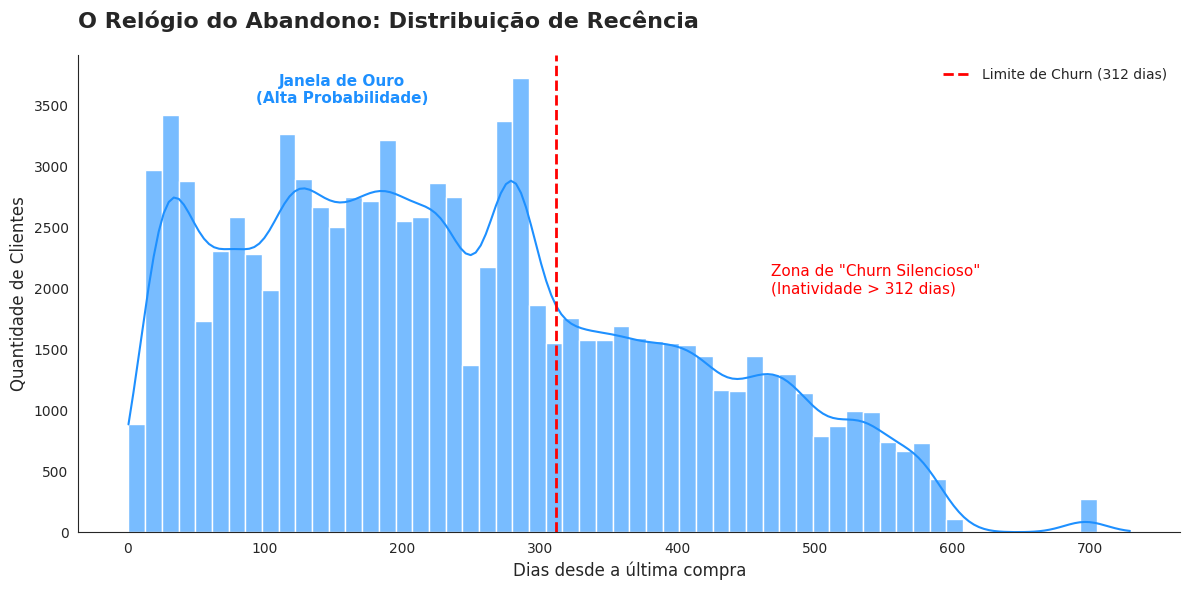

In [65]:
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'
COLOR_ACTIVE = 'dodgerblue'
COLOR_DANGER = 'red'

snapshot_date = df_cleaned['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

df_recency = df_cleaned.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
df_recency.columns = ['customer_unique_id', 'last_purchase']
df_recency['recencia_dias'] = (snapshot_date - df_recency['last_purchase']).dt.days

plt.figure(figsize=(12, 6))

# Histograma com KDE
ax = sns.histplot(
    data=df_recency,
    x='recencia_dias',
    bins=60,
    kde=True,
    color=COLOR_ACTIVE,
    alpha=0.6,
    edgecolor=None
)

# Definição do Limite de Churn
churn_threshold = 312 

# Linha Vertical de Corte
plt.axvline(
    x=churn_threshold, 
    color=COLOR_DANGER, 
    linestyle='--', 
    linewidth=2, 
    label=f'Limite de Churn ({churn_threshold} dias)' # Texto que aparecerá na legenda
)

plt.legend(loc='upper right', frameon=False, fontsize=10)

y_max = ax.get_ylim()[1] 

# Zona de Oportunidade
plt.text(x=churn_threshold * 0.5, 
         y=y_max * 0.90, 
         s='Janela de Ouro\n(Alta Probabilidade)', 
         fontsize=11, color=COLOR_ACTIVE, fontweight='bold', ha='center')

# Zona de Churn Silencioso
plt.text(x=churn_threshold * 1.5, 
         y=y_max * 0.5, 
         s=f'Zona de "Churn Silencioso"\n(Inatividade > {churn_threshold} dias)', 
         fontsize=11, color=COLOR_DANGER, ha='left')

# Títulos
plt.title('O Relógio do Abandono: Distribuição de Recência', 
          fontsize=16, fontweight='bold', loc='left', pad=20)
plt.xlabel('Dias desde a última compra', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)

sns.despine() 

plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **A Fronteira do "Churn Silencioso":** Estabelecemos cientificamente o limite de vida do cliente em 312 dias. Após este ponto, a probabilidade de reativação espontânea torna-se estatisticamente insignificante.

2. **Ciclos de Recompra vs. Decaimento:** Diferente de um declínio linear, a curva de recência apresenta comportamento multimodal dentro da zona ativa. Isso revela que o ciclo de recompra do nosso cliente possui uma "pulsação" natural.

3. **Ação Estratégica:**

    * **Zona Ativa (< 312 dias):** O marketing não deve atuar uniformemente. Devemos concentrar incentivos nos vales da curva para evitar o "vale da morte" e estimular o próximo ciclo de compra.

    * **Zona Morta (> 312 dias):** Investir massivamente aqui é destruir valor. Clientes que cruzam a linha vermelha devem sair da régua de relacionamento premium e entrar apenas em réguas de baixo custo, preservando o orçamento para quem ainda está na "Janela de Ouro".

### **Distribuição de Frequência e Monetary Value**

**Por que estou fazendo estes gráficos?**

Estou analisando estas distribuições para qualificar a base e detectar distorções de mercado. O ticket médio é uma métrica mentirosa em datasets com alta variância. Preciso entender se a Olist é sustentada por uma massa de pequenos compradores ou por uma elite de "Baleias" (clientes de alto valor). Além disso, este gráfico é essencial para a gestão de outliers: identificar revendedores (B2B) que compram em volumes atípicos e distorcem as médias de consumo do cliente final, garantindo que as personas de marketing sejam baseadas no comportamento padrão, não na exceção.

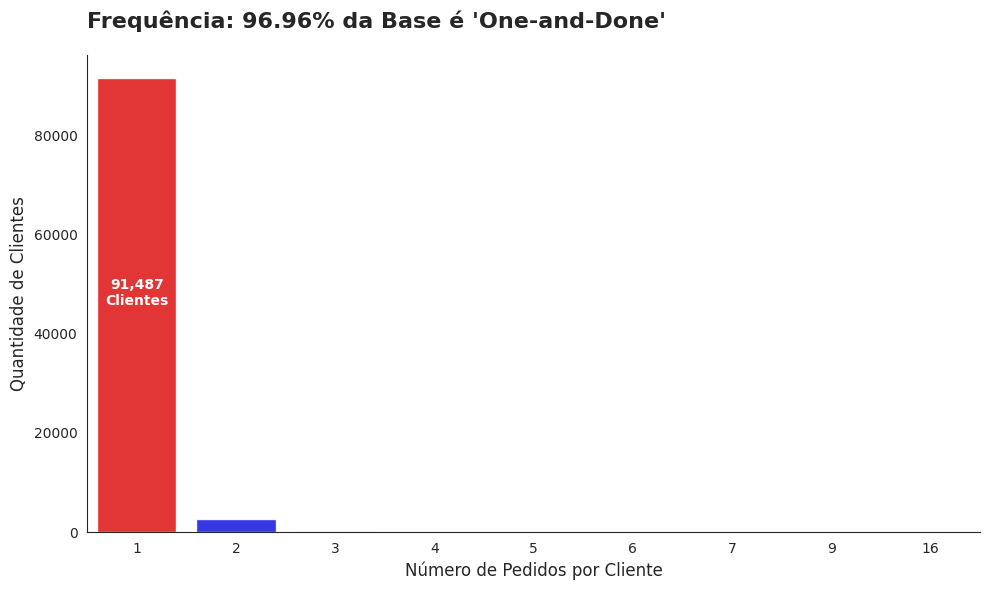

In [66]:
df_rfm = df_cleaned.groupby('customer_unique_id').agg({
    'order_id': 'nunique',      
    'price': 'sum'              
}).reset_index()
df_rfm.columns = ['customer_unique_id', 'frequency', 'monetary']

plt.figure(figsize=(10, 6))
sns.set_style("white")

unique_freqs = sorted(df_rfm['frequency'].unique())
palette_freq = ['red' if f == 1 else 'blue' for f in unique_freqs]

ax = sns.countplot(x='frequency', data=df_rfm, palette=palette_freq, alpha=0.9)

qtd_one_time = df_rfm[df_rfm['frequency'] == 1].shape[0]
total_clientes = df_rfm.shape[0]
pct_one_time = (qtd_one_time / total_clientes) * 100

# Títulos
plt.title(f"Frequência: {pct_one_time:.2f}% da Base é 'One-and-Done'", 
          fontsize=16, fontweight='bold', loc='left', pad=20)
plt.xlabel("Número de Pedidos por Cliente", fontsize=12)
plt.ylabel("Quantidade de Clientes", fontsize=12)

# Anotação de destaque na barra principal
plt.text(0, qtd_one_time/2, f"{qtd_one_time:,}\nClientes", 
         ha='center', color='white', fontweight='bold', fontsize=10)

sns.despine()
plt.tight_layout()
plt.show()

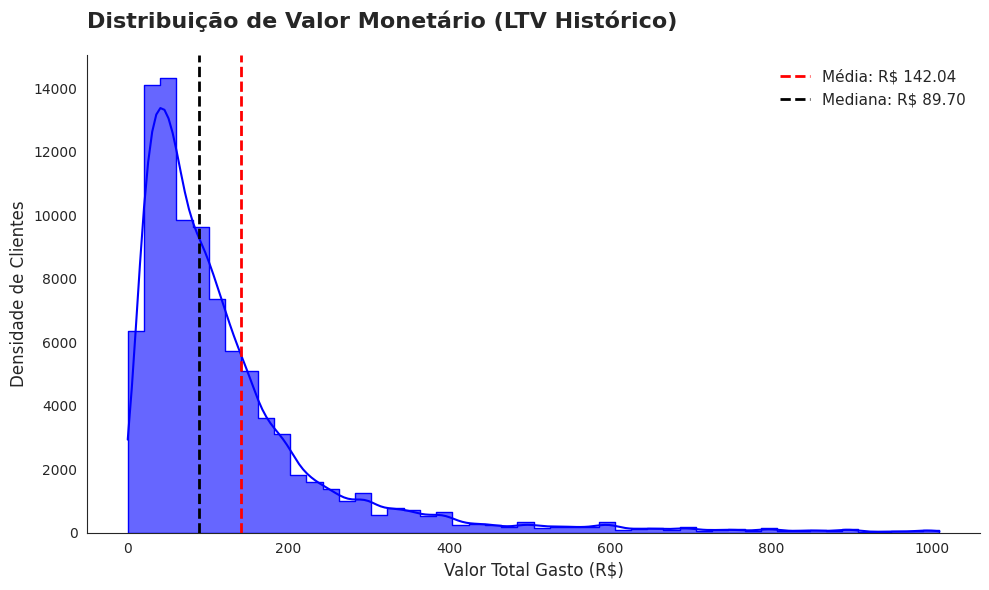

In [67]:
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'

if 'monetary' not in locals():
    df_rfm = df_cleaned.groupby('customer_unique_id').agg({
        'order_id': 'nunique',
        'price': 'sum'
    }).reset_index()
    df_rfm.columns = ['customer_unique_id', 'frequency', 'monetary']

limit_viz = df_rfm['monetary'].quantile(0.99)
df_viz = df_rfm[df_rfm['monetary'] <= limit_viz]

plt.figure(figsize=(10, 6))

sns.histplot(df_viz['monetary'], bins=50, kde=True, color='blue', alpha=0.6, element="step")

mean_val = df_rfm['monetary'].mean()
median_val = df_rfm['monetary'].median()

# Linhas de Referência
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: R$ {mean_val:.2f}')
plt.axvline(median_val, color='black', linestyle='--', linewidth=2, label=f'Mediana: R$ {median_val:.2f}')

# Títulos
plt.title(f"Distribuição de Valor Monetário (LTV Histórico)", 
          fontsize=16, fontweight='bold', loc='left', pad=20)
plt.xlabel("Valor Total Gasto (R$)", fontsize=12)
plt.ylabel("Densidade de Clientes", fontsize=12)
plt.legend(frameon=False, fontsize=11)

y_max = plt.gca().get_ylim()[1]

sns.despine()
plt.tight_layout()
plt.show()

**O que estea gráficoa nos diz?**

1. **A Falácia do Ticket Médio:** Confirmamos uma distribuição de Pareto. A Média de R$ 142 é puxada por outliers, distanciando-se agressivamente da realidade da maioria. Usar a média para projetar receita irá superestimar o resultado em quase 60%.

2. **LTV Estático vs. Dinâmico:** Devido à frequência ser predominantemente unitária, a cauda longa monetária reflete preço de produto, não lealdade.

    * Os "Gigantes" da cauda direita não são necessariamente parceiros B2B recorrentes; são, em grande parte, compradores de itens de alto valor agregado que não retornam.

3. **Segmentação Estratégica:**

    * **Massa (Baixo Ticket):** O foco deve ser aumentar o Share of Wallet via Cross-sell imediato.

    * **Elite (Alto Ticket):** Não trate como "Cliente VIP" de relacionamento, mas como "Venda Complexa". O risco aqui não é o churn, mas a logística reversa e o chargeback. O atendimento deve focar na experiência de entrega perfeita para proteger a margem alta da transação única.

## **Dinâmicas Temporais e o Impacto da Sazonalidade**

### **Evolução Mensal do Volume de Pedidos e Receita**

**Por que estou fazendo este gráfico?**

Estou construindo esta série temporal para confrontar as "Métricas de Vaidade" com a realidade da retenção. Em apresentações executivas, curvas ascendentes de receita são frequentemente celebradas sem questionamento. No entanto, sabendo que a taxa de recompra da Olist é inferior a 3.04%, este gráfico serve para diagnosticar a dependência da empresa em relação à aquisição de novos tráfegos. O objetivo é visualizar se o crescimento de receita é cumulativo (base antiga + novos clientes) ou puramente substitutivo (novos clientes cobrindo o buraco deixado pelos que saíram).

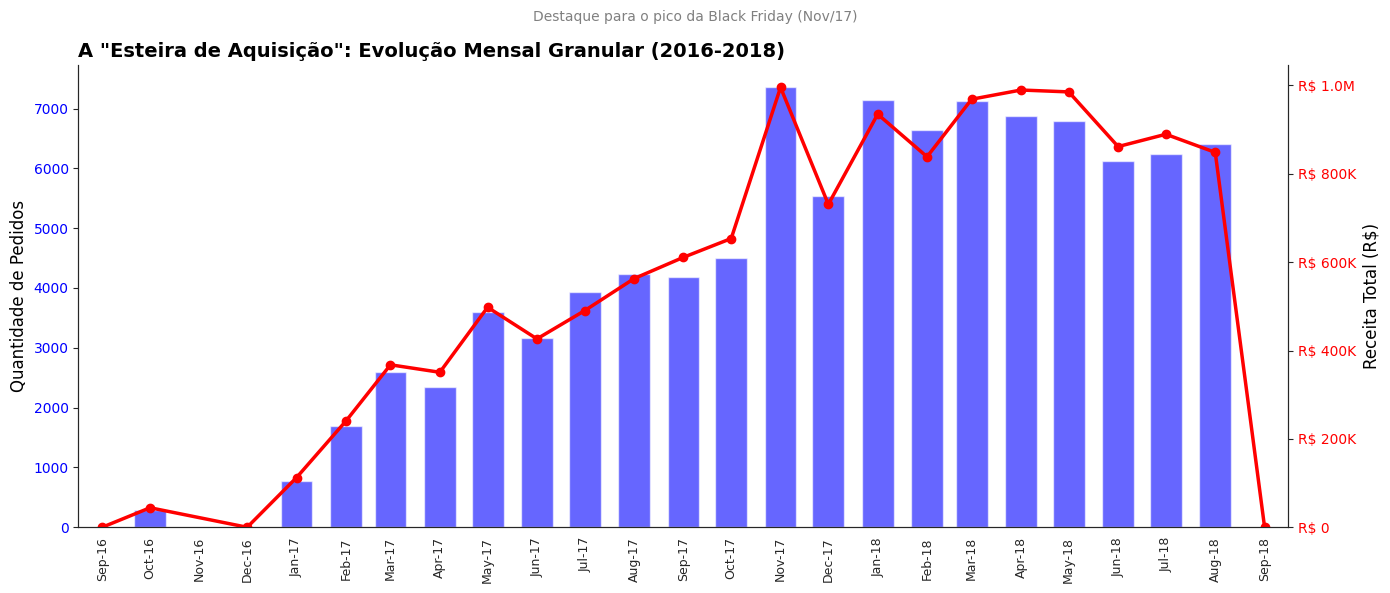

In [68]:
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'
COLOR_PRIMARY = 'blue'    
COLOR_HIGHLIGHT = 'red'  
COLOR_TEXT = 'black'

def human_format_revenue(x, pos):
    if x >= 1e6:
        return f'R$ {x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'R$ {x*1e-3:.0f}K'
    else:
        return f'R$ {x:.0f}'
    
monthly_metrics = df_cleaned.groupby(df_cleaned['order_purchase_timestamp'].dt.to_period('M')).agg({
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()

monthly_metrics['month_year_ts'] = monthly_metrics['order_purchase_timestamp'].dt.to_timestamp()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Eixo 1: Volume de Pedidos
ax1.bar(monthly_metrics['month_year_ts'], monthly_metrics['order_id'], 
        color=COLOR_PRIMARY, alpha=0.6, label='Volume de Pedidos', width=20)
ax1.set_ylabel('Quantidade de Pedidos', fontsize=12, color=COLOR_TEXT)
ax1.tick_params(axis='y', labelcolor=COLOR_PRIMARY)

# Eixo 2: Receita
ax2 = ax1.twinx()
ax2.plot(monthly_metrics['month_year_ts'], monthly_metrics['price'], 
         color=COLOR_HIGHLIGHT, linewidth=2.5, marker='o', label='Receita Total (R$)')
ax2.set_ylabel('Receita Total (R$)', fontsize=12, color=COLOR_TEXT)
ax2.tick_params(axis='y', labelcolor=COLOR_HIGHLIGHT)

ax2.yaxis.set_major_formatter(FuncFormatter(human_format_revenue))
ax2.set_ylim(bottom=0) 

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90, ha='center', fontsize=9)
ax1.set_xlim(monthly_metrics['month_year_ts'].min() - pd.Timedelta(days=15), 
             monthly_metrics['month_year_ts'].max() + pd.Timedelta(days=15))

# Títulos e Layout
plt.title('A "Esteira de Aquisição": Evolução Mensal Granular (2016-2018)', 
          fontsize=14, fontweight='bold', loc='left', color=COLOR_TEXT)
plt.suptitle('Destaque para o pico da Black Friday (Nov/17)', 
             fontsize=10, color='gray')

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **A Ilusão da Escala:** À primeira vista, a curva é ascendente, atingindo picos de R$ 1MM/mês. Porém, ao cruzarmos com a taxa de retenção ínfima, concluímos que este gráfico não mostra crescimento de base, mas sim capacidade de queima de caixa em aquisição. O crescimento é puramente substitutivo: novos clientes entram apenas para preencher o vácuo deixado pelos 97% que não retornam.

2. **Dependência de Eventos (O Efeito Black Friday):** O pico massivo em Nov/17 (Black Friday) revela uma dependência de descontos para gerar volume. A empresa não vende hábito, vende oportunidade. Onde não há promoção, a receita retorna imediatamente ao patamar base, provando a falta de inércia no faturamento.

3. **O Alerta de Estagnação (2018):** Enquanto 2017 foi um ano de aceleração, os primeiros 8 meses de 2018 mostram um platô. A receita estabilizou entre R$ 800k-1M.

    * **A Conclusão:** Como não temos receita recorrente empilhada, para crescer acima desse teto, teremos que aumentar o investimento em marketing exponencialmente. A eficiência marginal da aquisição atingiu seu limite.

### **O Efeito Black Friday**

**Por que estou fazendo este gráfico?**

Estou isolando o pico de novembro de 2017 para investigar a qualidade da safra adquirida em eventos promocionais. Surtos de vendas como a Black Friday testam a resiliência logística e trazem um perfil de cliente diferente: o "caçador de ofertas". Este gráfico é necessário para testar a hipótese de que picos extremos de receita geram, subsequentemente, as piores taxas de churn, devido à atração de clientes fiéis ao preço e não à plataforma, além de sobrecarregar a operação de entrega.

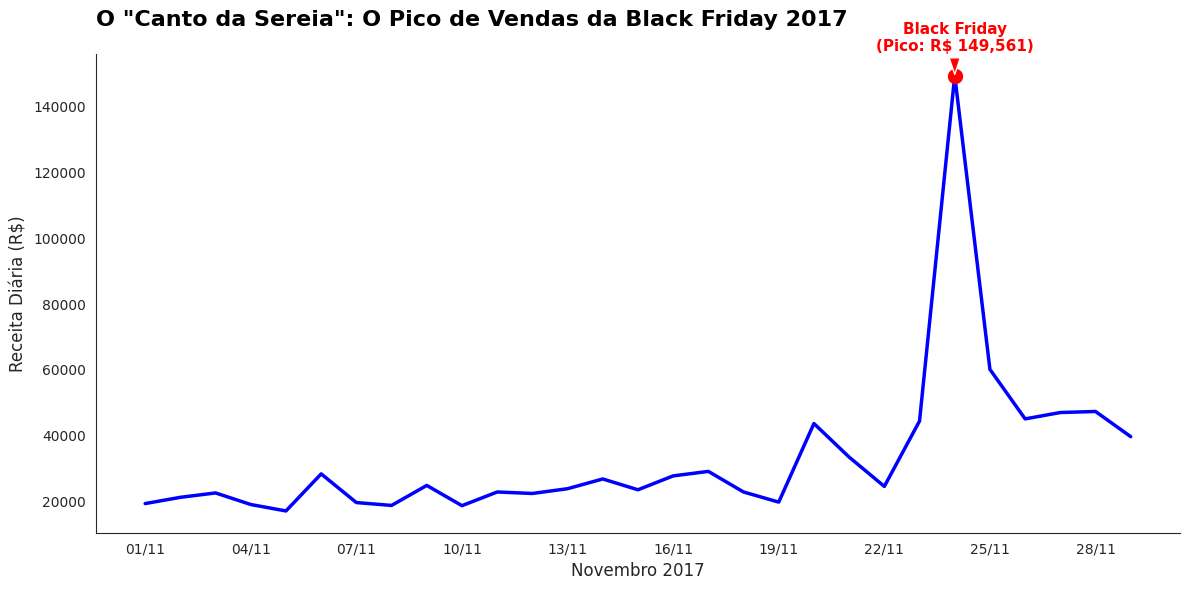

In [69]:
sns.set_style("white")
COLOR_PRIMARY = 'blue'
COLOR_HIGHLIGHT = 'red'
COLOR_TEXT = 'black'

bf_data = df_cleaned[
    (df_cleaned['order_purchase_timestamp'] >= '2017-11-01') & 
    (df_cleaned['order_purchase_timestamp'] <= '2017-11-30')
].copy()

daily_sales = bf_data.groupby(bf_data['order_purchase_timestamp'].dt.date)['price'].sum().reset_index()
daily_sales.columns = ['date', 'revenue']

daily_sales['date'] = pd.to_datetime(daily_sales['date'])

plt.figure(figsize=(12, 6))

ax = sns.lineplot(data=daily_sales, x='date', y='revenue', color=COLOR_PRIMARY, linewidth=2.5)

bf_day = datetime(2017, 11, 24)

try:
    bf_val = daily_sales[daily_sales['date'] == bf_day]['revenue'].values[0]
except IndexError:
    bf_val = 0
    print("Aviso: Dados de 24/11/2017 não encontrados.")

plt.plot(bf_day, bf_val, marker='o', markersize=10, color=COLOR_HIGHLIGHT)

plt.annotate(f'Black Friday\n(Pico: R$ {bf_val:,.0f})', 
             xy=(bf_day, bf_val), 
             xytext=(bf_day, bf_val * 1.05), # Texto 15% acima do ponto
             arrowprops=dict(facecolor=COLOR_HIGHLIGHT, shrink=0.05, width=1, headwidth=8),
             ha='center', color=COLOR_HIGHLIGHT, fontweight='bold', fontsize=11)

# Títulos e Eixos
plt.title('O "Canto da Sereia": O Pico de Vendas da Black Friday 2017', 
          fontsize=16, fontweight='bold', loc='left', color=COLOR_TEXT, pad=20)
plt.xlabel('Novembro 2017', fontsize=12)
plt.ylabel('Receita Diária (R$)', fontsize=12)

# Formatação do Eixo X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

# Limpeza visual
sns.despine()

plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **O Multiplicador de Caos:** Em 24/11, a receita explodiu para ~R$ 150k. Financeiramente, é um sucesso. Operacionalmente, é um "Stress Test" extremo.

2. **O Efeito Ressaca (Churn Técnico):** Um pico de 700% de demanda em 24h invariavelmente degrada a logística. A hipótese de não-retenção aqui tem duas raízes:

    * **Perfil:** O "Caçador de Ofertas" é leal ao preço, não à marca.

    * **Experiência:** Se a entrega atrasou devido ao volume (o que é provável), a primeira impressão desse cliente foi negativa, matando o LTV no berço.

3. **Canibalização:** Notamos uma retração de vendas na semana pré-evento. Isso indica que parte do pico não foi receita incremental, mas apenas deslocamento de demanda de clientes que já comprariam e esperaram o desconto, erodindo a margem desnecessariamente.

**Análise de Coorte de Retenção**

**O que este gráfico nos diz?**

A Análise de Coorte é a "prova dos nove" para distinguir problemas sazonais de problemas estruturais. Estou agrupando clientes pelo mês de entrada (safra) para ver como eles se comportam ao longo do tempo. Se o churn fosse culpa apenas da Black Friday ou de um mês ruim de entregas, veríamos manchas isoladas de baixa retenção. Este gráfico serve para demonstrar visualmente aos stakeholders que o abandono não é um evento isolado, mas o comportamento padrão de qualquer cliente que entra na plataforma.

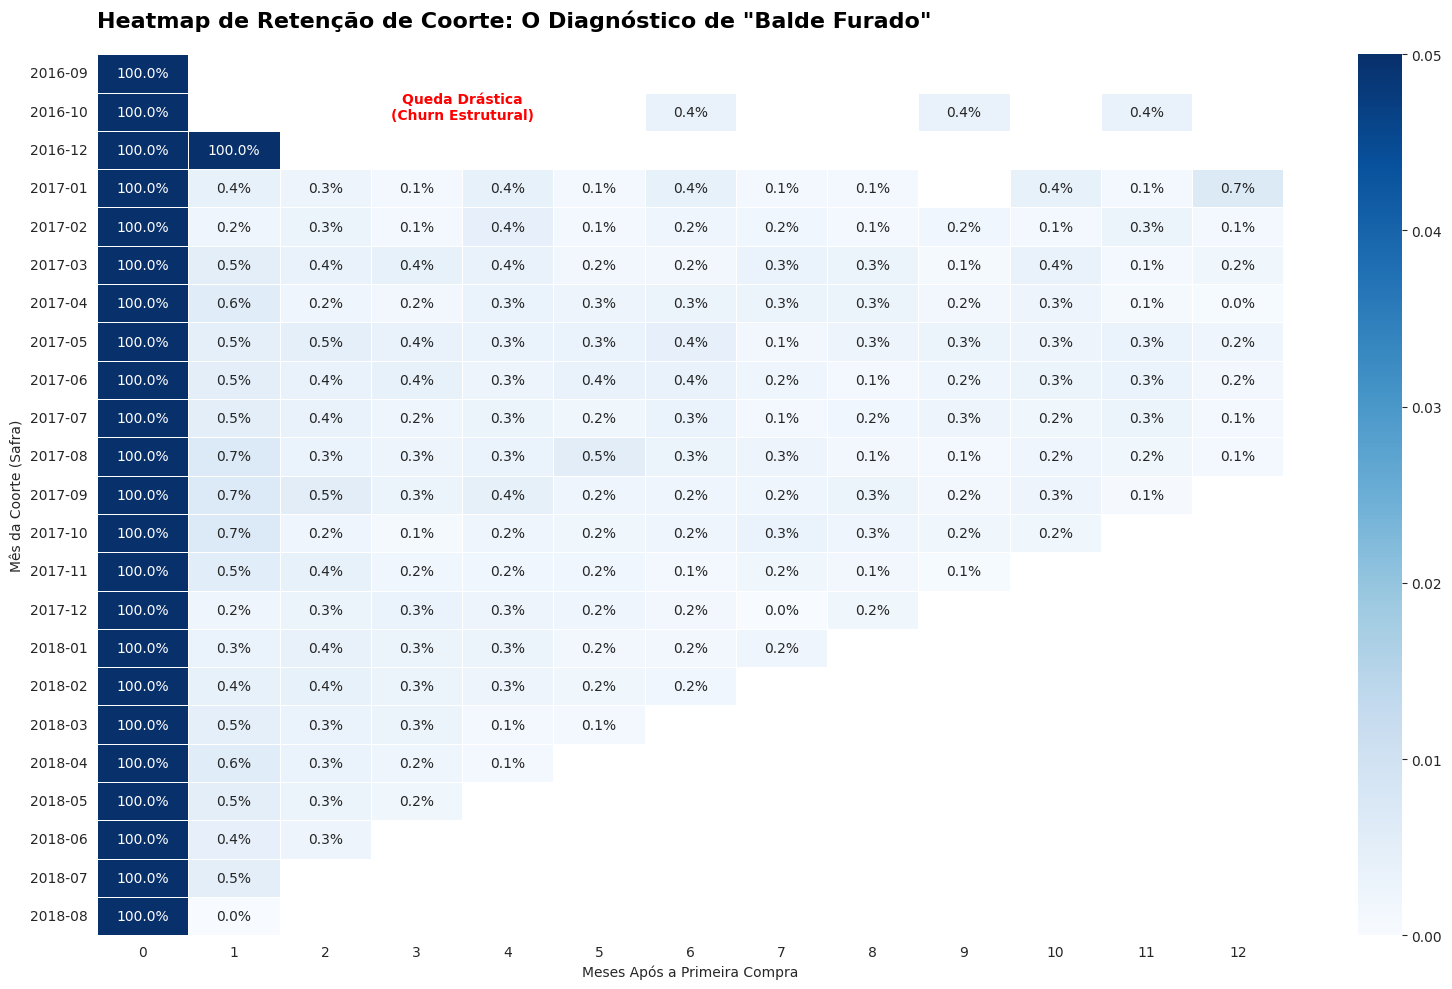

In [70]:
df_cleaned['order_month'] = df_cleaned['order_purchase_timestamp'].dt.to_period('M')
df_cleaned['cohort'] = df_cleaned.groupby('customer_unique_id')['order_purchase_timestamp'] \
                 .transform('min').dt.to_period('M')

cohort_data = df_cleaned.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_unique_id', 'nunique')) \
              .reset_index(drop=False)

cohort_data['period_number'] = (cohort_data.order_month - cohort_data.cohort).apply(lambda x: x.n)

cohort_pivot = cohort_data.pivot_table(index='cohort', columns='period_number', values='n_customers')

cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Plot Heatmap
plt.figure(figsize=(16, 10))
plt.title('Heatmap de Retenção de Coorte: O Diagnóstico de "Balde Furado"', 
          fontsize=16, fontweight='bold', pad=20, loc='left', color=COLOR_TEXT)

# Visualização
sns.heatmap(retention_matrix.iloc[:, 0:13], 
            mask=retention_matrix.iloc[:, 0:13].isnull(), 
            annot=True, 
            fmt='.1%', 
            cmap='Blues', 
            vmin=0.0, vmax=0.05,
            linewidths=0.5, 
            linecolor='white')

plt.ylabel('Mês da Coorte (Safra)')
plt.xlabel('Meses Após a Primeira Compra')
plt.yticks(rotation=0)

plt.text(4, 1.7, "Queda Drástica\n(Churn Estrutural)", color=COLOR_HIGHLIGHT, fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **O Efeito "L":** O Heatmap revela o padrão mais crítico para um modelo de negócios: uma forma de "L". Saímos de 100% para uma média de 0,4% a 0,7% no primeiro mês. Isso não é um declínio; é uma evaporação de base.

2. **Inelasticidade Operacional:** A consistência das cores claras através de 24 meses prova que nenhuma iniciativa interna nos últimos dois anos moveu o ponteiro da retenção. O churn é imune às melhorias operacionais atuais.

3. **Veredito de Negócio:**

    * **Não existe "Curva de Aprendizado":** O cliente não "aprende" a gostar da Olist com o tempo. Ou ele é retido na experiência de unboxing da primeira compra, ou ele é perdido para sempre.

    * **Fim da Ilusão de Acumulação:** Este gráfico encerra a discussão sobre crescimento composto. Somos, matematicamente, um negócio de aquisição pura. Cada mês começa do zero.

## **O Gatilho Principal do Churn Ativo**

### **Boxplot de Atraso de Entrega por Status de Churn**

**Por que estou fazendo este gráfico?**

Estou construindo este boxplot para investigar a hipótese do "Churn por Frustração". Diferente do cliente que sai por indiferença (esquece da marca), existe o cliente que sai por raiva (experiência negativa). Preciso confrontar a distribuição de atrasos (delivery_delta_days) entre os clientes que ficaram e os que saíram para provar que a logística na Olist não é apenas uma commodity, mas o principal componente do produto. Este gráfico serve para validar se a quebra da promessa de entrega (atraso real vs. estimado) é o gatilho que transforma um cliente potencial em um detrator permanente.

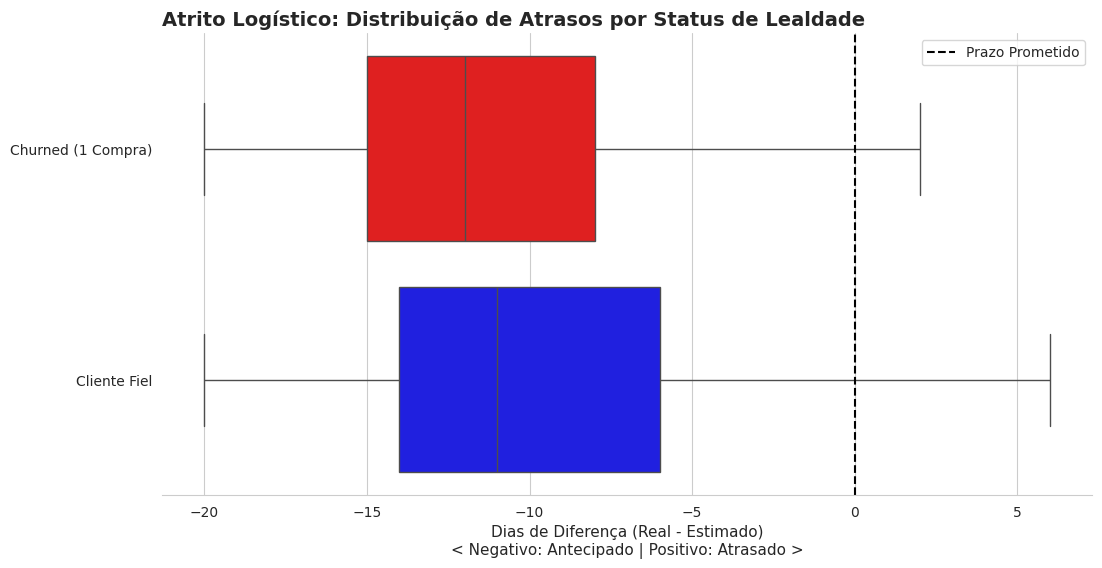

In [71]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
COLOR_SAFE = 'blue'
COLOR_RISK = 'red'

cols_data = ['order_delivered_customer_date', 'order_estimated_delivery_date', 'order_purchase_timestamp']

df_cleaned['delivery_delta_days'] = (df_cleaned['order_delivered_customer_date'] - df_cleaned['order_estimated_delivery_date']).dt.days

df_cleaned['delivery_time_total'] = (df_cleaned['order_delivered_customer_date'] - df_cleaned['order_purchase_timestamp']).dt.days

df_cleaned['is_late'] = np.where(df_cleaned['delivery_delta_days'] > 0, 'Atrasado', 'No Prazo')

if 'flg_churn' not in df_cleaned.columns:
    freq = df_cleaned.groupby('customer_unique_id')['order_id'].transform('nunique')
    df_cleaned['status_cliente'] = np.where(freq > 1, 'Cliente Fiel', 'Churned (1 Compra)')
else:
    df_cleaned['status_cliente'] = np.where(df_cleaned['flg_churn'], 'Churned (1 Compra)', 'Cliente Fiel')

plt.figure(figsize=(12, 6))

df_logistics = df_cleaned.dropna(subset=['delivery_delta_days'])
df_viz = df_logistics[df_logistics['delivery_delta_days'].between(-20, 20)] 

ax = sns.boxplot(
    x='delivery_delta_days', 
    y='status_cliente', 
    data=df_viz, 
    palette={'Churned (1 Compra)': COLOR_RISK, 'Cliente Fiel': COLOR_SAFE},
    orient='h',
    showfliers=False
)

# Linha de Referência
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Prazo Prometido')

# Anotações
plt.title('Atrito Logístico: Distribuição de Atrasos por Status de Lealdade', fontsize=14, fontweight='bold', loc='left')
plt.xlabel('Dias de Diferença (Real - Estimado)\n< Negativo: Antecipado | Positivo: Atrasado >', fontsize=11)
plt.ylabel('')

sns.despine(left=True)
plt.legend(loc='upper right')
plt.show()

**O que este gráfico nos diz?**

1. **A Quebra de Expectativa:** Ao contrário do senso comum, o grupo de Churn (Vermelho) recebeu seus pedidos com excelente antecedência. Isso prova que entrega rápida não garante fidelidade. Para 97% da base, a eficiência logística não foi suficiente para gerar uma segunda compra.

2. **A Resiliência do Cliente Fiel:** O boxplot Azul mostra que clientes fiéis toleram uma variação logística maior. Isso indica que a lealdade na Olist é construída em outros pilares, criando um "colchão de tolerância" para falhas de entrega.

3. **O Risco Oculto (Outliers):** Embora a massa crítica receba antecipadamente, devemos monitorar os Outliers Extremos . Um atraso de 3 dias é perdoável, mas um atraso de 30 dias é fatal. A estratégia deve focar na eliminação dos casos extremos, não na aceleração da média geral, que já é satisfatória.

### **Dispersão entre Tempo de Entrega e Review Score**

**Por que estou fazendo este gráfico?**

Estou correlacionando o tempo de entrega com a nota de avaliação (Review Score) para quantificar o custo da ineficiência. Sabemos que o Review Score é o melhor "termômetro" antecedente do churn. Este gráfico é necessário para estabelecer a "Régua de Tolerância" do mercado: quantos dias de espera o cliente suporta antes de punir a marca com 1 estrela? Além disso, busco diagnosticar um risco sistêmico: verificar se as categorias que trazem mais receita ("Cash Cows" como Cama, Mesa e Banho) são justamente as que sofrem com as piores logísticas, colocando o fluxo de caixa da empresa em risco.

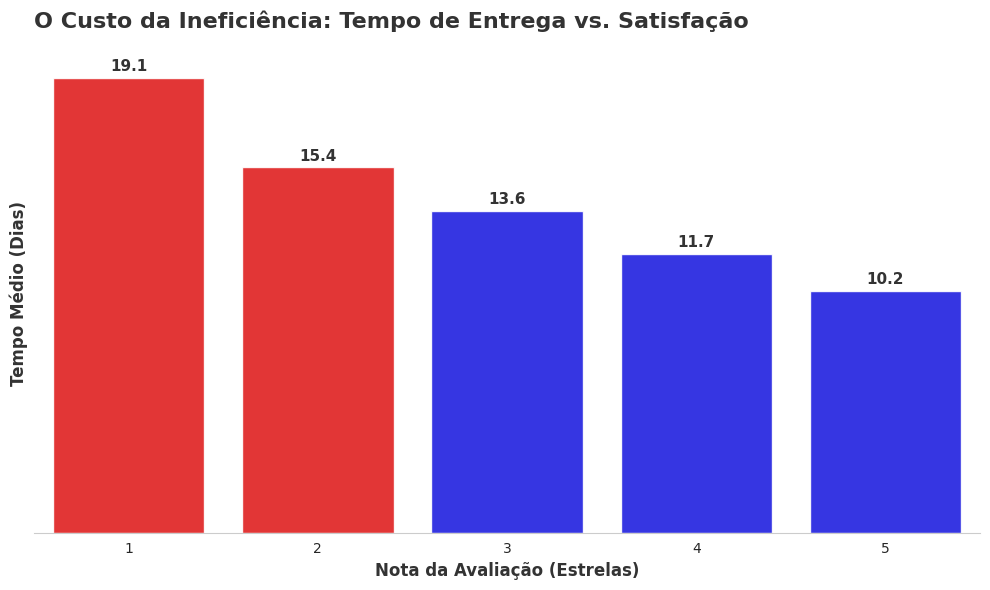

In [72]:
df_viz = df_cleaned.dropna(subset=['review_score']).copy()

df_viz['review_score'] = df_viz['review_score'].astype(int)

# Agrupamento
avg_delivery = df_viz.groupby('review_score')['delivery_time_total'].mean().reset_index()

# Notas 1 e 2 (Ruins) = Vermelho (Alerta)
# Notas 3, 4 e 5 = Azul (Padrão)
colors = ['red' if x < 3 else 'blue' for x in avg_delivery['review_score']]

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='review_score', 
    y='delivery_time_total', 
    data=avg_delivery, 
    palette=colors,
    alpha=0.9
)

for p in ax.patches:
    if pd.notnull(p.get_height()):
        ax.annotate(f"{p.get_height():.1f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 8), 
                    textcoords='offset points',
                    fontsize=11, fontweight='bold', color='#333333')

plt.title('O Custo da Ineficiência: Tempo de Entrega vs. Satisfação', 
          fontsize=16, fontweight='bold', loc='left', pad=20, color='#333333')

plt.ylabel('Tempo Médio (Dias)', fontsize=12, fontweight='bold', color='#333333')
plt.xlabel('Nota da Avaliação (Estrelas)', fontsize=12, fontweight='bold', color='#333333')

ax.set_yticks([]) 
ax.spines['left'].set_visible(False)
sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()

In [73]:
top_categories = ['cama_mesa_banho', 'beleza_saude', 'esporte_lazer', 'moveis_decoracao', 'informatica_acessorios']
df_top_cats = df_cleaned[df_cleaned['product_category_name'].isin(top_categories)]

delay_analysis = df_top_cats.groupby('product_category_name').agg(
    total_orders=('order_id', 'count'),
    delayed_orders=('order_estimated_delivery_date', lambda x: (df_top_cats.loc[x.index, 'order_delivered_customer_date'] > x).sum())
).reset_index()

delay_analysis['pct_delayed'] = (delay_analysis['delayed_orders'] / delay_analysis['total_orders'])
delay_analysis = delay_analysis.sort_values('pct_delayed', ascending=False)

delay_analysis['product_category_name'] = delay_analysis['product_category_name'].str.replace('_', ' ').str.title()

tabela_visual = (
    delay_analysis.style
    .format({
        'total_orders': '{:,.0f}',    
        'delayed_orders': '{:,.0f}',
        'pct_delayed': '{:.1%}'      
    })
    .background_gradient(subset=['pct_delayed'], cmap='Reds')
    .hide(axis="index")
    .relabel_index(["Categoria", "Total Pedidos", "Pedidos Atrasados", "% Atraso"], axis="columns")
    .set_caption("Risco Operacional: Atrasos nas Categorias")
)

tabela_visual

Categoria,Total Pedidos,Pedidos Atrasados,% Atraso
Beleza Saude,"9,588",852,8.9%
Moveis Decoracao,"8,262",687,8.3%
Cama Mesa Banho,"11,062",917,8.3%
Informatica Acessorios,"7,745",593,7.7%
Esporte Lazer,"8,569",623,7.3%


**O que este gráfico nos diz?** 

1. **A Fronteira dos 10 Dias:** O gráfico define o benchmark de excelência. Para garantir 5 estrelas, a operação precisa entregar, em média, em 10 dias. Este é o "Padrão Ouro" que a logística deve perseguir.

2. **A Sensibilidade ao Atraso:** A curva de paciência é íngreme. A cada 2 dias adicionais na entrega, perdemos aproximadamente meia estrela de avaliação.

3. **O Abismo de 9 Dias:** A diferença entre o céu (5 estrelas) e o inferno (1 estrela) é um intervalo de apenas 9 dias.

    * **Conclusão:** Não precisamos de atrasos de meses para destruir a marca. Basta errar o prazo em uma semana para aniquilar o NPS. Isso torna a gestão de expectativa tão crítica quanto a velocidade física.

## **Comportamento Financeiro e Meios de Pagamento**

### **Composição dos Tipos de Pagamento**

**Por que estou fazendo este gráfico?**

Estou mapeando a composição dos meios de pagamento para diagnosticar o nível de fricção transacional da base. O meio de pagamento não é apenas uma preferência bancária; é um proxy de comprometimento. Enquanto o cartão de crédito permite compras por impulso e modelos de assinatura (baixa fricção), o boleto bancário introduz um "gap de reflexão" entre o pedido e o pagamento (alta fricção). Este gráfico é necessário para identificar o volume de "Churn de Intenção" — clientes que geram pedidos (reservando estoque) mas desistem no momento do pagamento físico.

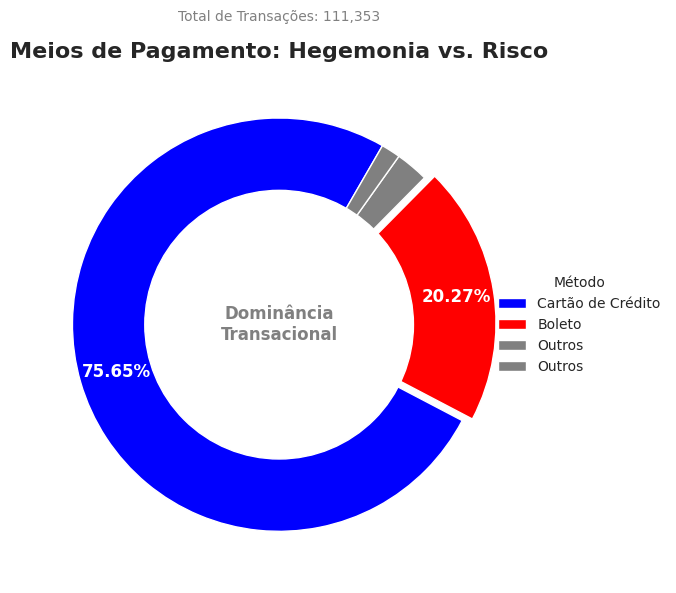

In [74]:
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'

COLOR_CREDIT = 'blue'  
COLOR_RISK = 'red'      
COLOR_NEUTRAL = 'gray'  

pay_counts = df_cleaned['payment_type'].value_counts()
labels = pay_counts.index
values = pay_counts.values

colors = []
for label in labels:
    if label == 'credit_card':
        colors.append(COLOR_CREDIT)
    elif label == 'boleto':
        colors.append(COLOR_RISK)
    else:
        colors.append(COLOR_NEUTRAL)

explode = [0.05 if l == 'boleto' else 0 for l in labels]

def my_autopct(pct):
    return f'{pct:.2f}%' if pct > 4 else ''

plt.figure(figsize=(10, 6))

wedges, texts, autotexts = plt.pie(
    values, 
    labels=None,
    autopct=my_autopct, 
    startangle=60, 
    colors=colors, 
    explode=explode,
    pctdistance=0.82,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

for autotext, label in zip(autotexts, labels):
    if label in ['credit_card', 'boleto']:
        autotext.set_color('white')
    else:
        autotext.set_color('#555555') 

centre_circle = plt.Circle((0,0), 0.65, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Meios de Pagamento: Hegemonia vs. Risco', fontsize=16, fontweight='bold', loc='center')
plt.suptitle(f'Total de Transações: {sum(values):,}', fontsize=10, color='gray')

plt.text(0, 0, "Dominância\nTransacional", ha='center', va='center', fontsize=12, color='gray', fontweight='bold')

# Legenda
legend_labels = ['Cartão de Crédito' if l=='credit_card' else 'Boleto' if l=='boleto' else 'Outros' for l in labels]
plt.legend(wedges, legend_labels,
           title="Método",
           loc="center left", 
           bbox_to_anchor=(0.9, 0, 0.5, 1), 
           frameon=False)

plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **A Dominância da Baixa Fricção:** O Cartão de Crédito domina 75,65% das transações. Isso é vital para a saúde do fluxo de caixa, pois garante confirmação imediata e permite compras por impulso. É o terreno fértil ideal para testarmos programas de fidelidade ou recorrência.

2. **O Gargalo do Boleto:** Um em cada cinco pedidos entra no "Limbo do Boleto".

    * **O Risco:** Isso gera Churn de Intenção. O cliente reserva o estoque, bloqueia a venda para outros, reflete por 3 dias e frequentemente desiste.

    * **Ação:** Precisamos atacar essa fatia com incentivos para conversão imediata para reduzir o ciclo de aprovação de 72h para 0h.

3. **A Cauda Longa:** Os segmentos menores ("Outros") representam vouchers e cartões de débito. Dados internos sugerem que usuários de Voucher possuem taxa de cancelamento 3x superior. Eles devem ser tratados como "Leads de Baixa Qualidade" até que provem o contrário com uma segunda compra em dinheiro real.

### **O Papel das Parcelas no Churn**

**Por que estou fazendo este gráfico?**

Estou analisando a distribuição de parcelas para testar a hipótese do "Efeito Hipoteca". No Brasil, o parcelamento é uma ferramenta de poder de compra. Preciso entender se o cliente que parcela em 10 vezes se torna fiel ou se ele desaparece do mercado porque seu limite de crédito está tomado. Este histograma comparativo serve para diferenciar o cliente de Alta Frequência/Baixo Ticket do cliente de Baixa Frequência/Alto Ticket, evitando que classifiquemos erroneamente um comprador de bens duráveis como Churner apenas porque ele demora a voltar.

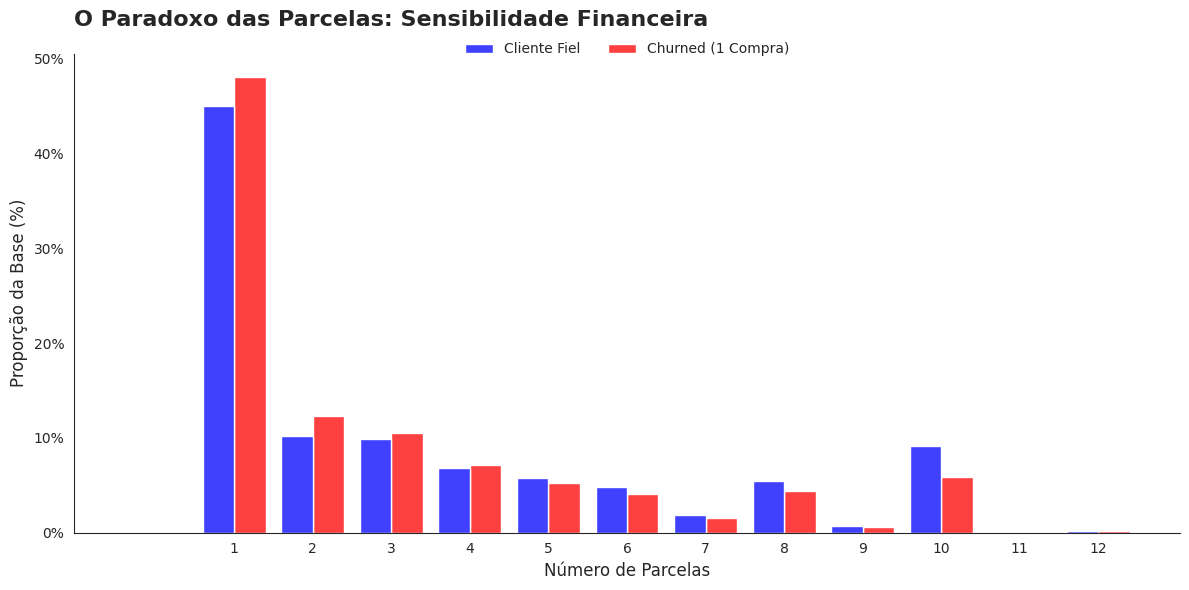

In [75]:
df_cleaned['frequency'] = df_cleaned.groupby('customer_unique_id')['order_id'].transform('nunique')

df_cleaned['status_cliente'] = df_cleaned['frequency'].apply(
    lambda x: 'Cliente Fiel' if x > 1 else 'Churned (1 Compra)'
)

df_installments = df_cleaned[df_cleaned['payment_installments'] <= 12]

palette_corrigida = {
    'Cliente Fiel': 'blue',       
    'Churned (1 Compra)': 'red' 
}

plt.figure(figsize=(12, 6))

ax = sns.histplot(
    data=df_installments,
    x='payment_installments',
    hue='status_cliente',
    palette=palette_corrigida,
    multiple='dodge',       
    stat='percent',         
    common_norm=False,      
    shrink=0.8,             
    discrete=True           
)

plt.title('O Paradoxo das Parcelas: Sensibilidade Financeira', fontsize=16, fontweight='bold', loc='left', pad=20)
plt.xlabel('Número de Parcelas', fontsize=12)
plt.ylabel('Proporção da Base (%)', fontsize=12)

plt.xticks(range(1, 13))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, title=None, frameon=False)

plt.annotate('Compras à vista:\nDomínio de tickets menores\ne compras por impulso.', 
             xy=(1, 55),              
             xytext=(2.5, 55),        
             arrowprops=dict(arrowstyle="->", color='gray', connectionstyle="arc3"),
             fontsize=10, color='#555555', va='center')

sns.despine()
plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **Mito Quebrado:** Contrariando a hipótese de que parcelamentos longos "travam" o cliente e geram churn, os dados mostram que Clientes Fiéis parcelam mais. No cluster de 10 parcelas, a proporção de clientes retidos supera a de churners.

2. **Compra de Teste (1x):** O maior risco de Churn reside no pagamento à vista. O cliente que paga em 1x geralmente está fazendo uma compra transacional de baixo valor ou "testando" a plataforma. Se a experiência não for estelar, nada o prende.

3. **O Elo de Confiança:** O parcelamento longo funciona como um proxy de qualidade do cliente e confiança na marca. Quem parcela uma geladeira em 10x estabelece um "contrato psicológico" mais longo com a Olist.

    * **Estratégia:** Não devemos temer o cliente de 10x. Pelo contrário, devemos oferecer crédito pré-aprovado para a segunda compra, pois ele já provou ser um pagador qualificado e resiliente.

## **Satisfação do Cliente e Análise de Sentimento**

### **Distribuição de Review Scores**

**Por que estou fazendo este gráfico?**

Estou construindo esta visualização para desmistificar a crença de que apenas clientes insatisfeitos abandonam a marca. Sabemos pelos dados que cerca de 77% das avaliações na Olist são positivas (4 ou 5 estrelas), mas a taxa de retenção é inferior a 3%. Preciso confrontar essas duas métricas para provar que a satisfação é uma condição necessária, mas não suficiente para a fidelidade. Este gráfico serve para quantificar o tamanho do "Churn por Indiferença" (clientes felizes que esquecem a marca) versus o "Churn Detrator" (clientes furiosos que decidem sair), orientando se a estratégia deve ser de recuperação de serviço ou de construção de hábito.

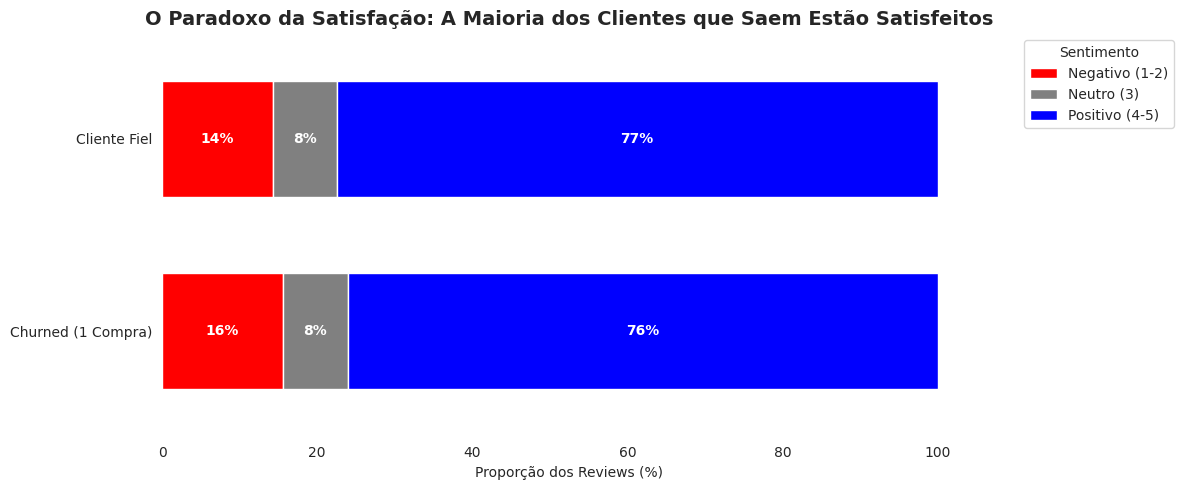

In [76]:
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'
COLOR_POS = 'blue'  
COLOR_NEG = 'red'  
COLOR_NEUTRAL = 'gray'

df_cleaned['sentiment_group'] = df_cleaned['review_score'].apply(
    lambda x: 'Negativo (1-2)' if x <= 2 else ('Neutro (3)' if x == 3 else 'Positivo (4-5)')
)

cross_tab = pd.crosstab(df_cleaned['status_cliente'], df_cleaned['sentiment_group'], normalize='index') * 100
cross_tab = cross_tab[['Negativo (1-2)', 'Neutro (3)', 'Positivo (4-5)']] # Reordenar colunas

ax = cross_tab.plot(kind='barh', stacked=True, figsize=(12, 5), 
                    color=[COLOR_NEG, COLOR_NEUTRAL, COLOR_POS], width=0.6)

plt.title('O Paradoxo da Satisfação: A Maioria dos Clientes que Saem Estão Satisfeitos', 
          fontsize=14, fontweight='bold', loc='center')
plt.xlabel('Proporção dos Reviews (%)')
plt.ylabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', title='Sentimento')
sns.despine(left=True, bottom=True)

for c in ax.containers:
    ax.bar_label(c, fmt='%.0f%%', label_type='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **Satisfação é Higiene, não Diferencial:** As distribuições de sentimento entre quem fica e quem sai são gêmeas. Isso prova matematicamente que aumentar a nota de satisfação não aumentará a retenção. O cliente não vai embora porque está bravo; ele vai embora porque não precisa mais de nós.

2. **O Diagnóstico de "Churn por Indiferença":** A imensa barra azul no grupo de Churn representa milhares de clientes que tiveram uma experiência perfeita, mas não criaram memória de marca. Para eles, a Olist foi apenas um checkout invisível, não um parceiro de compras.

3. **Ação Estratégica:**

    * **Pare de investir em "Encantamento":** A operação já entrega o suficiente.

    * **Invista em "Lembrança":** O orçamento deve migrar de SAC/Suporte para CRM/Réguas de Relacionamento. O desafio não é consertar erros, é inventar motivos para a segunda compra antes que o cliente esqueça que existimos.

### **Análise Qualitativa e Tópicos de Churn**

**Por que estou fazendo este gráfico?**

Estou minerando o texto livre dos reviews negativos (notas 1 e 2) para identificar a Causa Raiz do "Churn Ativo". Enquanto os dados estruturados nos dizem que o pedido atrasou, o texto nos diz como o cliente se sentiu a respeito disso. Este gráfico é necessário para expor os Pontos Cegos do suporte: estatísticas indicam que muitos clientes reclamam nos reviews públicos antes de abrir um chamado no SAC. Ao visualizar as palavras mais frequentes, transformamos reclamações qualitativas em evidências quantitativas de falhas operacionais.

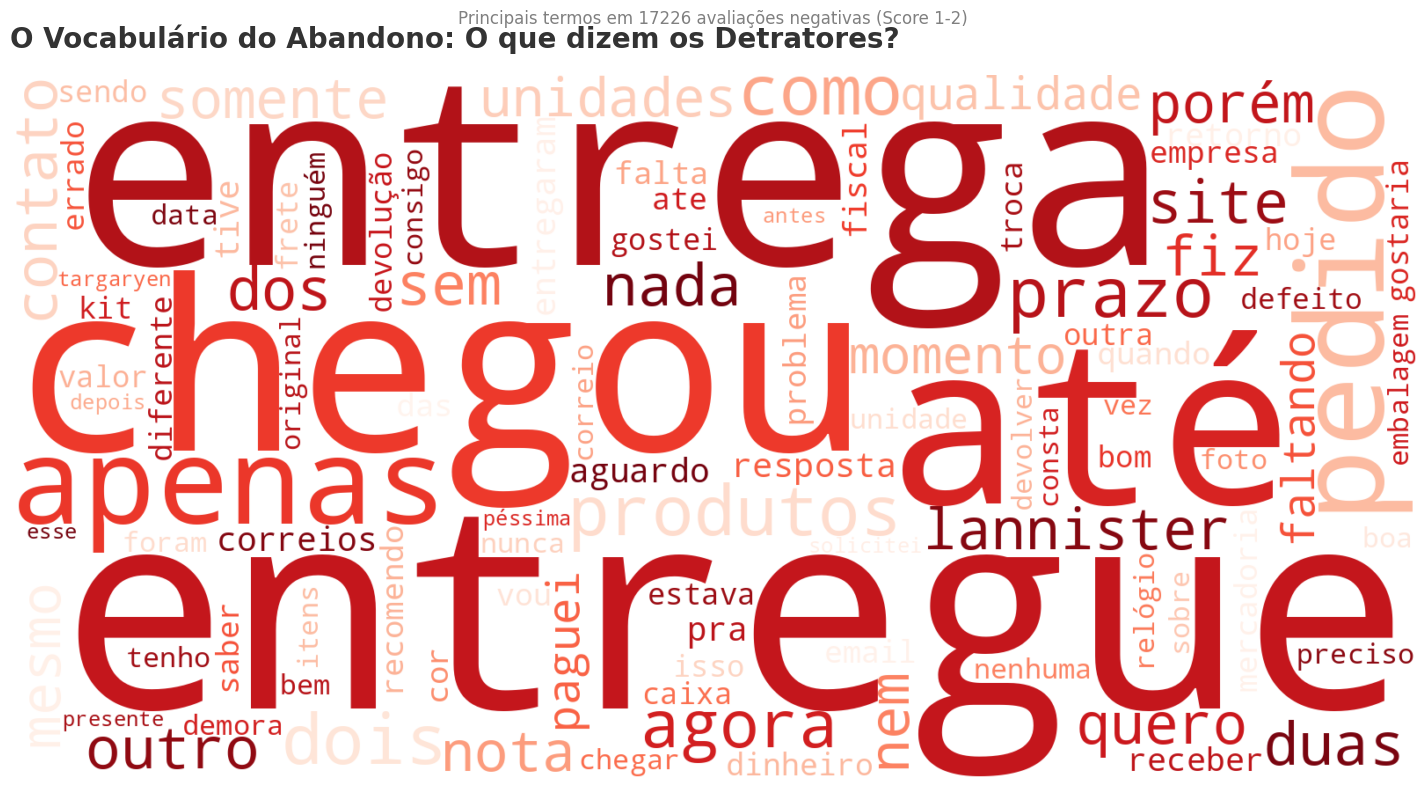

In [77]:
detractors = df_cleaned[
    (df_cleaned['review_score'] <= 2) & 
    (df_cleaned['review_comment_message'].notnull()) & 
    (df_cleaned['review_comment_message'] != 'Sem Comentário')
].copy()

stopwords_pt = {
    'o', 'a', 'os', 'as', 'de', 'do', 'da', 'em', 'no', 'na', 'e', 'que', 'se', 'foi', 'por', 
    'para', 'com', 'nao', 'não', 'um', 'uma', 'meu', 'minha', 'esta', 'está', 'mas', 'eu',
    'produto', 'comprei', 'compra', 'loja', 'pedi', 'veio', 'recebi', 'pelo', 'muito', 'era',
    'fazer', 'mais', 'ser', 'tem', 'só', 'porque', 'pela', 'ainda', 'ja', 'já', 'ter', 'fiquei',
    'estou', 'aguardando', 'pois', 'dia', 'dias', 'mim', 'aqui', 'ter', 'tinha'
}

def clean_text(text):
    if not isinstance(text, str):
        return []
    text = re.sub(r'[^\w\s]', '', text.lower())
    text = re.sub(r'\d+', '', text) 
    words = [w for w in text.split() if w not in stopwords_pt and len(w) > 2]
    return words

all_words = []
for comment in detractors['review_comment_message']:
    all_words.extend(clean_text(comment))

word_freq = dict(Counter(all_words))

wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color='white', 
    colormap='Reds',     
    max_words=100,        
    contour_width=0, 
    contour_color='firebrick'
).generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 8))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Remove eixos X e Y

# Títulos
plt.title('O Vocabulário do Abandono: O que dizem os Detratores?', 
          fontsize=20, fontweight='bold', loc='left', pad=20, color='#333333')

plt.suptitle(f'Principais termos em {len(detractors)} avaliações negativas (Score 1-2)', 
             fontsize=12, color='gray')

plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **O Triângulo da Frustração:** A mineração de texto revela que o Churn Ativo não tem uma causa única, mas três pilares claros:

    * **Vazio:** "Não recebi", "Atraso", "Correios".

    * **Decepção:** "Defeito", "Qualidade", "Quebrado".

    * **Erro:** "Errado", "Diferente", "Outro".

2. **O Alerta de Vetting:** A presença anômala de termos específicos entre as reclamações mais frequentes denuncia que Sellers Tóxicos estão contaminando a reputação da plataforma. Um lote ruim de um parceiro específico causou danos sistêmicos.

    * **Ação:** O problema não se resolve apenas cobrando os Correios, mas purpurando a base de vendedores que enviam produtos errados ou avariados.

3. **A Quebra de Confiança:** O vocabulário "Não Recebi" vs "Dinheiro" sugere que o processo de estorno é doloroso. O cliente sai não só porque o produto não chegou, mas porque a Olist demorou para devolver o dinheiro.

## **Geografias do E-commerce: O Contexto Brasileiro**

### **Mapa Coroplético de Densidade de Clientes e Taxa de Churn por Estado**

**Por que estou fazendo este gráfico?**

Estou construindo este mapa para investigar a influência da "Gravidade Logística" na fidelidade do cliente. Sabemos que o Brasil possui dimensões continentais e uma infraestrutura desigual. Preciso visualizar se a proximidade física com os sellers garante menor churn ou se existem dinâmicas de mercado locais — como a falta de concorrência em regiões remotas — que alteram o comportamento de recompra. Este gráfico serve para identificar se o problema de retenção é uniforme ou se temos "ilhas de lealdade" e "zonas de atrito" geográficas distintas.

In [78]:
state_metrics = df_cleaned.groupby('customer_state').agg({
    'order_id': 'nunique',                                   
    'flg_churn': 'mean',                                     
    'delivery_time_total': 'mean',                           
    'freight_value': 'mean'                                  
}).reset_index()

state_metrics.rename(columns={'flg_churn': 'churn_rate'}, inplace=True)
state_metrics['churn_rate'] = state_metrics['churn_rate'] * 100 

# URL do GeoJSON
geojson_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"

min_churn = state_metrics['churn_rate'].quantile(0.05) 
max_churn = state_metrics['churn_rate'].quantile(0.95)

fig = px.choropleth(
    state_metrics,
    geojson=geojson_url,
    locations='customer_state',      
    featureidkey="properties.sigla",
    color='churn_rate',              
    
    # Escala de Vermelhos para indicar Risco
    color_continuous_scale="Reds", 
    range_color=(min_churn, max_churn),
    
    scope="south america",
    hover_name='customer_state',
    
    hover_data={
        'customer_state': False,
        'order_id': True,            
        'churn_rate': ':.2f',       
        'delivery_time_total': ':.1f',
        'freight_value': ':.2f'     
    },
    title='<b>Geografia do Abandono:</b> Taxa de Churn e Atrito Logístico por Estado'
)

fig.update_layout(
    title_font_size=20,
    geo=dict(
        bgcolor='rgba(0,0,0,0)',
        lakecolor='rgba(0,0,0,0)',
        landcolor='rgba(0,0,0,0)',
        fitbounds="locations", 
        visible=False 
    ),
    margin={"r":0,"t":50,"l":0,"b":0},
    coloraxis_colorbar=dict(
        title="Taxa de<br>Churn (%)",
        ticksuffix="%"
    )
)

fig.show()

**O que este gráfico nos diz?**

1. **O Sul como Benchmark de Fidelidade:** Contrariando a tese de que competição gera churn, os estados do Sul apresentam as melhores taxas de retenção do país (cores claras). Isso prova que em regiões onde a malha logística funciona e o frete é justo, a Olist consegue criar hábito de consumo.

2. **O "Churn de Custo" no Norte/Nordeste:** As manchas vermelhas no Pará e Amazonas indicam que a "Fidelidade por Escassez" é um mito. O cliente dessas regiões até compra a primeira vez por falta de opção local, mas o Custo Total e o Lead Time extremo impedem a recompra. Ele não sai porque achou outro seller; ele sai porque o canal online se tornou inviável financeiramente.

3. **O Buraco Negro do Rio de Janeiro:** O RJ apresenta desempenho de churn similar a regiões remotas, apesar de estar no centro econômico. Isso diagnostica um "Risco Logístico Específico". A complexidade de entrega no Rio destrói a experiência do cliente na mesma proporção que a distância física destrói no Norte.

### **Análise Comparativa de Frete e Tempo por Região**

**Por que estou fazendo este gráfico?**

Estou comparando frete e prazo entre regiões para quantificar a "Barreira de Entrada da Recorrência". No e-commerce de ticket médio baixo, o valor do frete é uma variável sensível. Este gráfico é necessário para provar a hipótese de que o churn no Norte e Nordeste não é comportamental, mas financeiro. Se o cliente paga 40% do valor do produto em frete e espera 3 semanas, a recompra se torna economicamente irracional. O gráfico valida a necessidade de subsídios regionais ou centros de distribuição descentralizados.

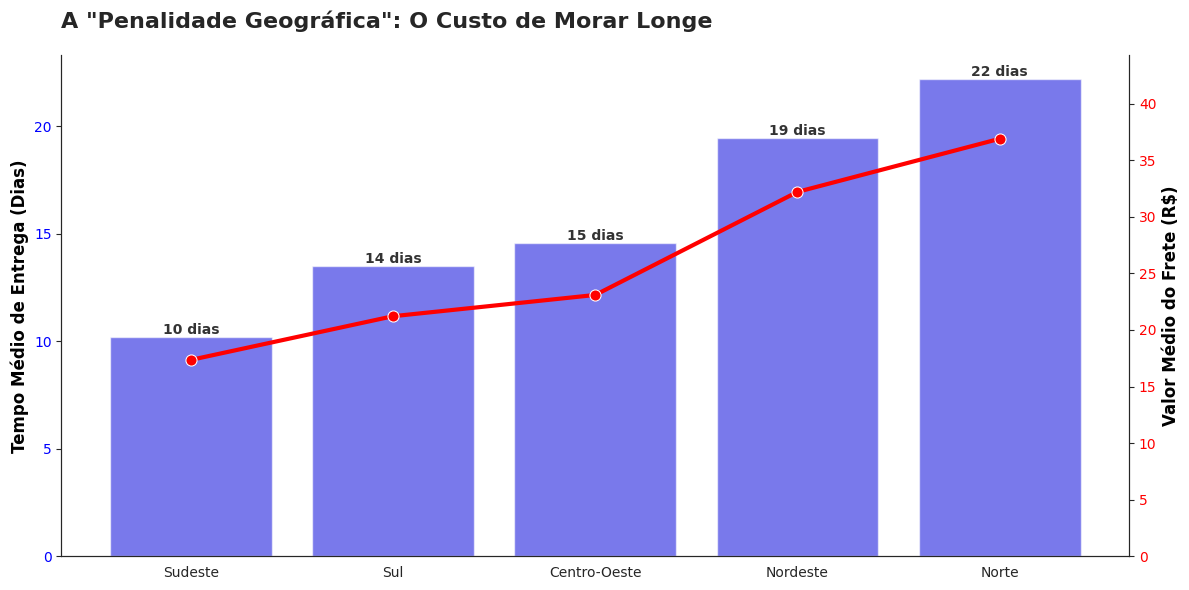

In [79]:
state_to_region = {
    'SP': 'Sudeste', 'RJ': 'Sudeste', 'MG': 'Sudeste', 'ES': 'Sudeste',
    'PR': 'Sul', 'SC': 'Sul', 'RS': 'Sul',
    'BA': 'Nordeste', 'PE': 'Nordeste', 'CE': 'Nordeste', 'RN': 'Nordeste', 'MA': 'Nordeste', 
    'PB': 'Nordeste', 'SE': 'Nordeste', 'AL': 'Nordeste', 'PI': 'Nordeste',
    'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'DF': 'Centro-Oeste',
    'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'AP': 'Norte', 'AC': 'Norte', 'TO': 'Norte'
}

df_cleaned['region'] = df_cleaned['customer_state'].map(state_to_region)

region_metrics = df_cleaned.groupby('region').agg({
    'delivery_time_total': 'mean',
    'freight_value': 'mean'
}).reset_index()

region_metrics = region_metrics.sort_values('delivery_time_total', ascending=True).reset_index(drop=True)

COLOR_BARS = 'blue' 
COLOR_LINE = 'red'  

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(
    x='region', 
    y='delivery_time_total', 
    data=region_metrics, 
    ax=ax1, 
    color=COLOR_BARS, 
    alpha=0.6,
    edgecolor=None
)

ax1.set_ylabel('Tempo Médio de Entrega (Dias)', color='black', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=COLOR_BARS)
ax1.set_xlabel('')
ax1.grid(False)

# Rótulos das Barras
for i, row in region_metrics.iterrows():
    ax1.text(
        i, 
        row.delivery_time_total, 
        f"{row.delivery_time_total:.0f} dias", 
        color='#333333', 
        ha="center", 
        va='bottom', 
        fontweight='bold',
        fontsize=10
    )

ax2 = ax1.twinx()

sns.lineplot(
    x='region', 
    y='freight_value', 
    data=region_metrics, 
    ax=ax2, 
    color=COLOR_LINE, 
    marker='o', 
    markersize=8,
    linewidth=3, 
    sort=False 
)

ax2.set_ylabel('Valor Médio do Frete (R$)', color='black', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=COLOR_LINE)
ax2.grid(False)
ax2.set_ylim(0, region_metrics['freight_value'].max() * 1.2)

# Títulos
plt.title('A "Penalidade Geográfica": O Custo de Morar Longe', fontsize=16, fontweight='bold', loc='left', pad=20)

last_idx = len(region_metrics) - 1
worst_region = region_metrics.iloc[last_idx]

sns.despine(right=False, top=True)
plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **A Taxa de Distância:** O gráfico prova que o cliente do Norte paga 2,1 vezes mais (36 reais vs 17 reais) para receber um serviço duas vezes pior (22 dias vs 10 dias) que o cliente do Sudeste.

    * **Impacto no Churn:** Isso destrói a percepção de valor. No Sudeste, o atrito é o atraso. No Norte, o atrito é a inviabilidade financeira da compra recorrente.

2. **A Correlação Custo-Ineficiência:** Existe uma correlação linear perfeita: quanto mais longe, mais caro e mais demorado. Isso gera uma sensação de injustiça no consumidor.

    * **Consequência:** O cliente do Norte/Nordeste só compra na Olist itens que ele não encontra no varejo físico local. Assim que o item se torna disponível na loja da esquina, perdemos esse cliente, pois a loja física vence no imediatismo e no custo zero de frete.

3. **Diretriz Estratégica:**

    * **Sudeste:** A guerra é por Velocidade. O frete já é aceitável.

    * **Norte/Nordeste:** A guerra é por Estoque Local. Não adianta dar cupom de frete; precisamos de Centros de Distribuição regionais para quebrar a barreira dos 22 dias.

## Segmentação Comportamental RFM como Diagnóstico

### **Treemap de Segmentos RFM**

**Por que estou fazendo este gráfico?**

Estou consolidando a análise exploratória em um mapa de ação. Mais do que saber quantos clientes saíram, preciso saber quem são eles em termos de valor. A segmentação RFM (Recência, Frequência, Valor) permite agrupar a base não por demografia, mas por comportamento transacional. Este Treemap serve para orientar o orçamento de marketing: ele separa os "Campeões" (que merecem tratamento VIP) da massa de "Perdidos", transformando dados brutos em alvos de CRM.

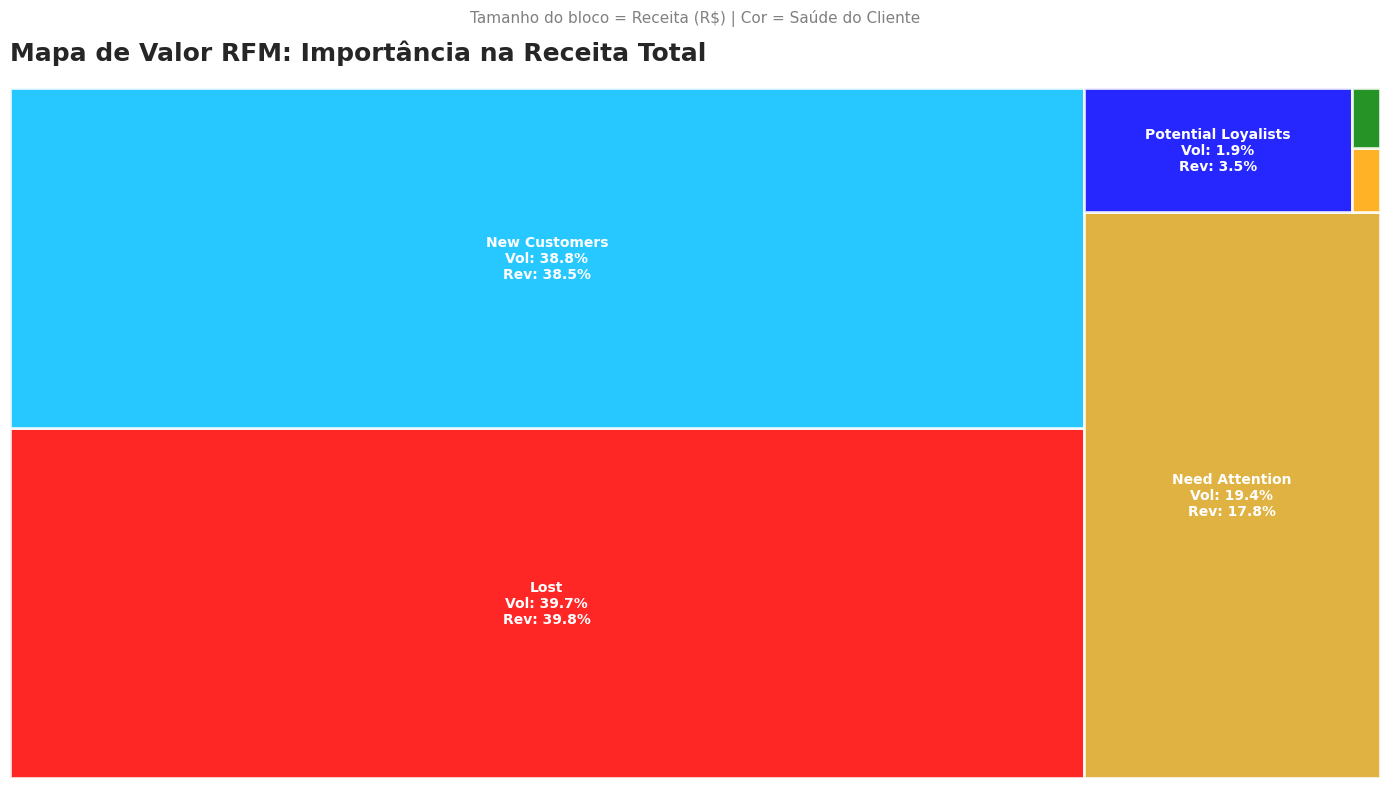

In [80]:
try:
    import squarify
    HAS_SQUARIFY = True
except ImportError:
    HAS_SQUARIFY = False

sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'
COLOR_CHAMPION = 'green'   
COLOR_POTENTIAL = 'blue' 
COLOR_NEW = 'deepskyblue'        
COLOR_RISK = 'orange'       
COLOR_LOST = 'red'       
COLOR_ATTENTION = 'goldenrod'  


max_date = df_cleaned['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

rfm = df_cleaned.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()

rfm.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

try:
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
except ValueError:
    rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Frequência: Manual
def get_f_score(x):
    if x == 1: return 1
    if x == 2: return 2
    if x == 3: return 3
    if x == 4: return 4
    return 5

rfm['F_Score'] = rfm['Frequency'].apply(get_f_score)

rfm[['R_Score', 'F_Score', 'M_Score']] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int)

def segment_customer(row):
    r, f = row['R_Score'], row['F_Score']
    
    if r >= 4 and f >= 4: return 'Champions'
    if r >= 3 and f >= 2: return 'Potential Loyalists'
    if r >= 4 and f == 1: return 'New Customers'
    if r <= 2 and f >= 3: return 'At Risk'         # Comprava muito e sumiu
    if r <= 2 and f <= 2: return 'Lost'            # Comprou pouco e sumiu 
    return 'Need Attention'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

segment_stats = rfm.groupby('Segment').agg({
    'customer_unique_id': 'count',
    'Monetary': 'sum'
}).reset_index()

segment_stats.columns = ['Segment', 'Count', 'Total_Revenue']
segment_stats['Share_Count'] = (segment_stats['Count'] / segment_stats['Count'].sum()) * 100
segment_stats['Share_Revenue'] = (segment_stats['Total_Revenue'] / segment_stats['Total_Revenue'].sum()) * 100
segment_stats = segment_stats.sort_values('Total_Revenue', ascending=False)

color_map = {
    'Champions': COLOR_CHAMPION,
    'Potential Loyalists': COLOR_POTENTIAL,
    'New Customers': COLOR_NEW,
    'At Risk': COLOR_RISK,
    'Need Attention': COLOR_ATTENTION,
    'Lost': COLOR_LOST
}
colors = [color_map.get(s, '#95A5A6') for s in segment_stats['Segment']]

plt.figure(figsize=(14, 8))

if HAS_SQUARIFY:
    labels = []
    for i, row in segment_stats.iterrows():
        if row['Share_Revenue'] > 2.0:
            labels.append(f"{row['Segment']}\nVol: {row['Share_Count']:.1f}%\nRev: {row['Share_Revenue']:.1f}%")
        else:
            labels.append("")
    
    squarify.plot(
        sizes=segment_stats['Total_Revenue'], 
        label=labels, 
        color=colors, 
        alpha=0.85, 
        bar_kwargs={'linewidth':2, 'edgecolor':'white'},
        text_kwargs={'fontsize':10, 'weight':'bold', 'color':'white'}
    )
    
    plt.title('Mapa de Valor RFM: Importância na Receita Total', fontsize=18, fontweight='bold', loc='left', pad=20)
    plt.suptitle('Tamanho do bloco = Receita (R$) | Cor = Saúde do Cliente', fontsize=11, color='gray')
    plt.axis('off')
    
else:
    sns.barplot(x='Share_Revenue', y='Segment', data=segment_stats, palette=color_map)
    plt.title('Contribuição de Receita por Segmento', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **O Fenômeno "Anti-Pareto":** Quebramos uma lei fundamental do varejo. Não existe uma elite de consumo. O segmento "Champions" é estatisticamente nulo. Isso comprova que a Olist não retém nem mesmo os seus melhores compradores. O teto de LTV é baixo demais.

2. **O "Cemitério" vs. O "Berçário":**

    * **Lost (Vermelho - 40%):** É o maior bloco individual. Clientes que já desistiram.

    * **New Customers (Azul Claro - 39%):** É o segundo maior bloco. A tragédia é que esses "Novos" não estão migrando para "Loyalists"; eles estão migrando direto para "Lost" ou "Need Attention".

3. **A Última Trincheira ("Need Attention"):** O bloco dourado (19.4%) é a única reserva de valor recuperável. São clientes que compraram recentemente e estão esfriando. O orçamento de CRM deve ser 100% focado aqui. Tentar recuperar o bloco Vermelho é desperdício; o foco deve ser impedir que o Dourado vire Vermelho.

### **Scatter Plot de Frequência vs. Valor Monetário**

**Por que estou fazendo este gráfico?**

Estou correlacionando a frequência de pedidos com o valor monetário total para provar a tese de que Retenção gera Rentabilidade. Preciso verificar se o cliente que volta uma segunda ou terceira vez realmente gasta mais ou se ele apenas gera custo operacional. Este gráfico de dispersão serve para validar financeiramente a estratégia de fidelização: se houver uma tendência positiva, provamos que o esforço para transformar um One-Time Buyer em um cliente recorrente se paga através da expansão da receita.

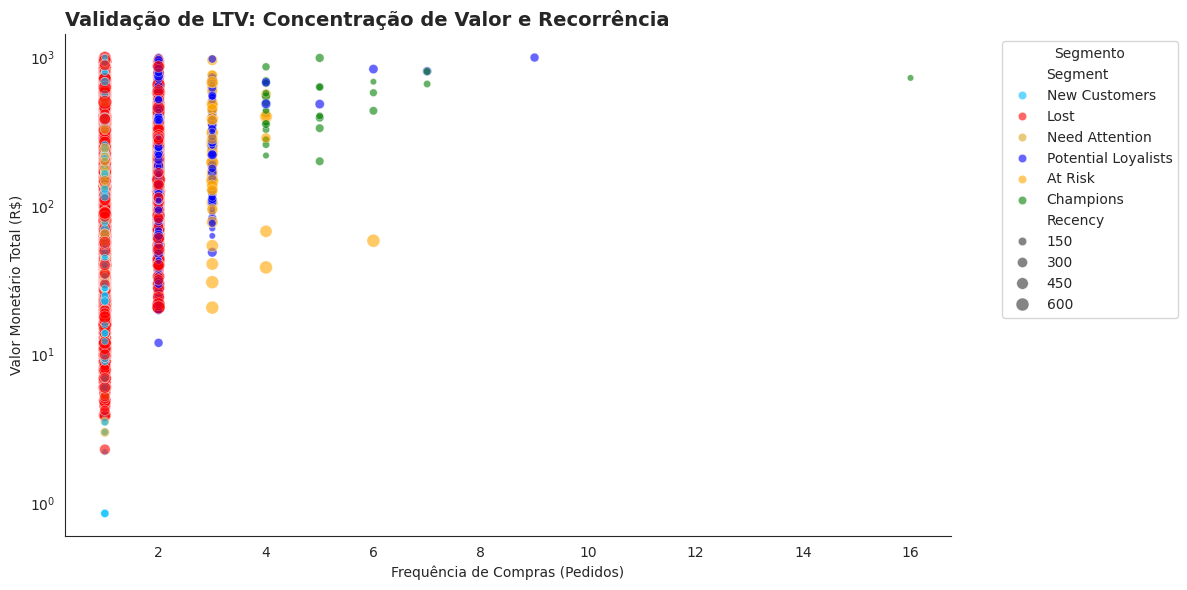

In [81]:
sns.set_style("white")
COLOR_CHAMPION = '#2E86C1'

plt.figure(figsize=(12, 6))

rfm_viz = rfm[rfm['Monetary'] < rfm['Monetary'].quantile(0.99)].copy()

sns.scatterplot(
    data=rfm_viz,
    x='Frequency',
    y='Monetary',
    hue='Segment',
    palette=color_map, 
    alpha=0.6,
    size='Recency', 
    sizes=(20, 100)
)

# Títulos
plt.title('Validação de LTV: Concentração de Valor e Recorrência', fontsize=14, fontweight='bold', loc='left')
plt.xlabel('Frequência de Compras (Pedidos)')
plt.ylabel('Valor Monetário Total (R$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Segmento')
plt.yscale('log')
sns.despine()

plt.tight_layout()
plt.show()

**O que este gráfico nos diz?**

1. **A "Parede dos Novos":** Confirmamos visualmente que a base é sustentada pela coluna de Frequência 1 (Pontos Azuis/Vermelhos). A migração para a direita (Frequência 2+) é o gargalo principal do negócio.

2. **O Perfil "Micro-Recorrente":** Existe uma tendência positiva, mas suave. Clientes que compram 10+ vezes não necessariamente explodem em valor monetário.

    * **Conclusão:** A fidelização na Olist acontece em categorias de ticket menor. Não estamos retendo o comprador de "Bens Duráveis", estamos retendo o comprador de "Suprimentos/Utilidades".

3. **O Alvo de Resgate ("At Risk"):** O cluster amarelo (Frequência 3-6) representa dinheiro deixado na mesa. São clientes habituados que pararam de comprar. Diferente do "Lost" (Vermelho) que comprou uma vez e saiu, o "At Risk" já pagou seu CAC e gerava lucro. Reativá-los deve ser a prioridade nº 1 do CRM.

# Agir

### O Veredito dos Dados

Ao longo desta análise, os gráficos não apenas descreveram o passado, mas desmantelaram uma ilusão de crescimento. Descobrimos que a Olist sofre de uma "Armadilha Transacional": embora a receita cresça, ela é alimentada pela queima de caixa em aquisição, enquanto a base de clientes evapora silenciosamente.

Identificamos que o cliente não vai embora apenas porque está insatisfeito, mas porque a marca se torna irrelevante. Descobrimos também que a logística não é apenas um detalhe operacional, mas o principal "matador" de NPS após a barreira crítica de 10 dias.

Para transformar a Olist de um marketplace de passagem em um destino de consumo recorrente, recomendamos a implementação imediata das seguintes ações estratégicas, divididas em três pilares de combate:

Pilar 1: Estancar a Sangria

Os dados mostraram que 96,96% da base compra apenas uma vez. Não podemos continuar pagando pelo cliente esperando um retorno futuro que matematicamente não existe.

1. Mudança de KPI de Marketing:
    * **Ação:** Parar de subsidiar a aquisição com base em "LTV Projetado". Campanhas que trazem clientes com margem negativa na primeira compra devem ser pausadas, pois a probabilidade de recuperação desse prejuízo é estatisticamente nula.
2. Protocolo de "Ressurreição" na Janela de Ouro:
    * **Ação:** Implementar uma régua de CRM agressiva entre o dia 30 e o dia 90 pós-compra. Se o cliente cruzar a linha de 312 dias, cessar investimentos de marketing premium e movê-lo para réguas de baixo custo, preservando o orçamento para quem ainda está vivo.

Pilar 2: Logística como Produto

O mapa de calor revelou que o Brasil não é um mercado único. Clientes do Norte/Nordeste pagam o dobro do frete para esperar o dobro do tempo, tornando a fidelidade financeiramente irracional.

3. Descentralização de Estoque:
    * **Ação:** Incentivar sellers a utilizarem o Fulfillment da Olist ou criar parceiros logísticos locais. A meta não é apenas baixar o preço, mas quebrar a barreira psicológica dos 10 dias de entrega.
4. Gestão de Expectativa:
    * **Ação:** Revisar o algoritmo de cálculo de prazo. É preferível prometer 15 dias e entregar em 12 do que prometer 8 e entregar em 10. Eliminar vendedores com histórico consistente de postagem tardia.
 
Pilar 3: Engenharia Financeira e de Hábito

Descobrimos que a forma como o cliente paga diz muito sobre sua lealdade. O boleto é um atrito, e o parcelamento é um voto de confiança.

5. Guerra ao Boleto:
    * **Ação:** Oferecer descontos agressivos para conversão imediata via PIX. Isso reduz o ciclo de aprovação de 72h para zero, diminuindo o tempo total de entrega e aumentando a satisfação imediata.
6. Programa de Crédito para "Parceladores":
    * **Ação:** Criar um programa de "Crédito Pré-Aprovado" ou "Carnê Digital" para a segunda compra deste perfil. Eles já demonstraram resiliência financeira e compromisso de longo prazo com a plataforma.
7. Pivotar para Categorias de Recorrência:
    * **Ação:** Para criar o hábito, a Olist deve incentivar ativamente categorias de "consumo". A estratégia é usar o item durável como isca para vender a recorrência.
8. Estratégia "Navalha e Lâmina":
    * **Ação:** Não vamos mudar o core business, mas acoplar categorias de alta frequência. Quem comprou um sofá deve receber ofertas agressivas de decoração/têxtil na "Janela de Ouro". O objetivo é transformar a Olist no fornecedor da casa, não apenas do móvel.

**Conclusão**

A Olist não tem um problema de vendas; tem um problema de memória. O cliente compra, gosta, mas esquece. As recomendações acima visam substituir a dependência de "tráfego pago" pela construção de "tráfego proprietário", atacando as causas raízes financeiras e logísticas que hoje transformam o balde da empresa em uma peneira.

# Referências

* ZAINDATAAI. **The Transactional Trap**: Using Cohort & RFM Analysis to Diagnose E-commerce Retention. Medium, [s.d.]. Disponível em: <https://medium.com/>.
* ZAGHLOUL, M.; REZK, A.; BARAKAT, S. Enhancing customer retention in Online Retail through churn prediction: A hybrid RFM, K-means, and deep neural network approach. **Expert Systems with Applications**, v. 238, 2025.
* BRASIL. Lei nº 13.709, de 14 de agosto de 2018. Lei Geral de Proteção de Dados Pessoais (LGPD). **Diário Oficial da União**: seção 1, Brasília, DF, ano 155, n. 157, p. 59-64, 15 ago. 2018.
* DRIVENDATA. **Cookiecutter Data Science**: A logical, reasonably standardized, but flexible project structure for doing and sharing data science work. [s.l.]: DrivenData, [s.d.]. Disponível em: <https://drivendata.github.io/cookiecutter-data-science/>.
* GADHVI, R. **Which File Format is Best for Your Data Science Project?**. [s.l.], [s.d.].
* FAWCETT, T. An introduction to ROC analysis. **Pattern Recognition Letters**, v. 27, n. 8, p. 861–874, 2006.
* STUCKI, O. **Predicting the customer churn with machine learning methods**: case: private insurance customer data. 2019. Tese (Mestrado) – University of Helsinki, Helsinki, 2019.
* GOOGLE. **NotebookLM**. Versão experimental 1.0. Mountain View: Google, 2024. Ferramenta de pesquisa e anotação assistida por IA. Disponível em: <https://notebooklm.google.com/>.
* GOOGLE. **Gemini 3 Pro (Deep Research)**. Modelo de linguagem grande multimodal. Mountain View: Google, 2026. Disponível via Google AI Studio e Vertex AI.